# What do employers want from a data scientist?

### Who does this analysis benefit? Who are potential stakeholders?

1. Let's support that I am an aspiring data scientist. Regardless of my current qualifications, I want to know what employers want so that I know what skills I need to go and acquire, or which of my skills I can best leverage. 

2. Let's suppose that we are a data science course provider / bootcamp based in London. Our bottom line is getting our learners hired in the data science world *and*, additionally, trying to maximise the average salaries our graduates get. To do so, we need to match our curriculum to what the market is asking for. What's the right combination of skills, programming languages and expertise that we should be delivering? That's a question we can answer by looking at employer demands. 

Broadly, data scientists have several overlapping categories of roles that they can go into. According to a Workera report, five of the main categories are:
1. Data Scientist
2. Data Analyst
3. Machine Learning Engineer
4. Machine Learning Researcher
5. Data Engineer
6. Software Engineer

To try and capture as much of the job categories that a recent bootcamp data scientist might be leaving for, I retrieved job data from Indeed.co.uk based on 3 searches. For each of these, my search results only returned job posts where the *title* of the job included the following pairs of words:
* data, scientist
* machine, learning
* data, analyst

The inclusion of the last two might seem questionable, but remember that we want to maximise the number of jobs our grads can aim for (so including data analyst roles, which are considered to be somewhat less specialist) are usefu

Those are the 3 categories we'll be working with. The data has some overlap. I'll be referring to the 3 respective search categories as DS, ML and DA data. The whole dataset is the Data Science dataset. 


Here are our questions that we'll be posing to the data:
1. How many data science jobs advertise salary?
2. What is the spread of salaries advertised for data scientist jobs on indeed.co.uk?
3. What are the main locations that data scientist roles appear in? (London expected to be the main one)
4. What are some of the most frequent words mentioned in the job title?
5. Which programming languages are in greatest demand? Do any of the languages correlate with higher salary?
6. Is there any relationship between years of experience required and salary?
7. What are the main topics emerging from the job descriptions and the title?

> ### P P D A C - Problem, Plan, Data, Analysis, Conclusion

* **Problem** - we have our questions about data science jobs
* **Plan** - scrape data from Indeed.co.uk using BS4 and Selenium; Extract key info using regex; plot data using Seaborn; carry out statistical tests (Point Biserial Coef.); Use LDA to look for latent topics in job descriptions.
* **Data** - Webscrapped job descriptions from Indeed.co.uk, searched for between 24th and 25th November, 2020. 
* **Analysis** - Barplots and boxplots illustrate salary distributions for London and non-London jobs. With an initial $\alpha$ of 0.05 I will run several NHST tests and report on results. 
* **Conclusion** - Report on any results from stat tests, report o



In [1]:
#§ Load the data and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import functions as fn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.sklearn
import topic_mod as topic
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
import scipy.stats as stats
sns.set_style('darkgrid')

df = pd.read_csv('clean_data/final_master.csv', index_col=0);
df.info();

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082 entries, 0 to 1081
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   company                              1082 non-null   object 
 1   job_title                            1082 non-null   object 
 2   job_descr                            1082 non-null   object 
 3   time_of_scrape                       1082 non-null   object 
 4   job_search_term                      1082 non-null   object 
 5   salary_from_page_source_as_stated    449 non-null    float64
 6   salary_from_page_source_conv_hourly  448 non-null    float64
 7   salary_from_page_source_time_period  448 non-null    object 
 8   Num_reviews                          573 non-null    float64
 9   Loc_from_title                       1082 non-null   object 
 10  date                                 1082 non-null   object 
dtypes: float64(3), object(8)
memor

In [2]:
df.job_search_term = df.job_search_term.apply(lambda x : x.replace('title:(data, scientist)', 'Data Scientist'))
df.job_search_term = df.job_search_term.apply(lambda x : x.replace('title:(data,analyst)', 'Data Analyst'))
df.job_search_term = df.job_search_term.apply(lambda x : x.replace('title:(machine, learning)', 'Machine Learning'))

## 1. How many data science jobs advertise salary?



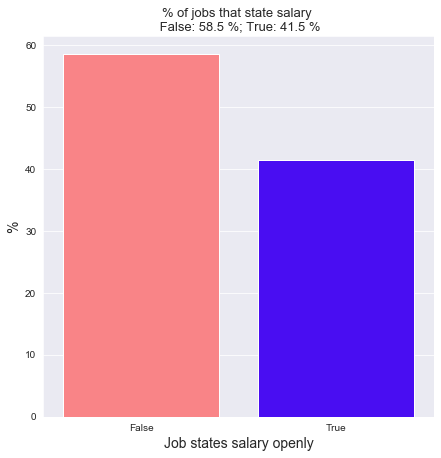

In [3]:
plt.figure(figsize=(7,7))
df['states_salary'] = ~df.salary_from_page_source_as_stated.isna()
g=df.groupby('states_salary').size().reset_index()
g.iloc[:,1] = round(g.iloc[:, 1]/len(df) * 100, 2)
plt.title(f'% of jobs that state salary \n False: {g.iloc[0,1]} %; True: {g.iloc[1,1]} %' , 
          fontdict={'size':13})
sns.barplot(data=g, x='states_salary', y=g.iloc[:,1],  palette='gnuplot2_r', saturation=0.9)
plt.xlabel('Job states salary openly', fontdict={'size':14})
plt.ylabel('%', fontdict={'size':14,},)
plt.savefig('fig/percent_jobs_state_salary.jpg')
plt.show()

<div class="alert alert-block alert-success">

From the perspective of an young, fresh data science grad or someone fresh out of a bootcamp, one challenge they'll face is salary negotiation - particularly daunting when most jobs do not directly state their salary. This applies across the board to all 3 categories, although the gap is wider for DA and ML roles. 

For the bootcamp's organisers, this makes it even more important that they research salary estimates thorroughly and inform their students of this - to help reach the goal of maximising average salary of bootcamp grads they should also be given help with salary negotiation: 

    
#### Recommendation 1: Include at least 1 salary negotiation lesson / workshop in curriculum to maximise expected average salary of graduates. 
    
</div>    


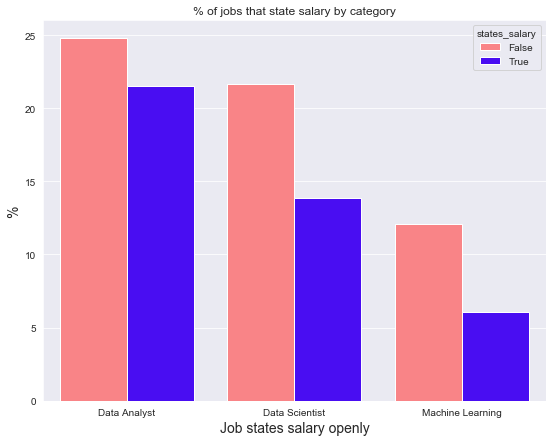

In [4]:
plt.figure(figsize=(9,7))
g=df.groupby(['states_salary', 'job_search_term']).size().reset_index()
g.iloc[:,2] = round(g.iloc[:, 2]/len(df) * 100, 2);
plt.title(f'% of jobs that state salary by category') # \n False: {g.iloc[0,1]} %; True: {g.iloc[1,1]} %' , 
         # fontdict={'size':13})
sns.barplot(data=g, hue='states_salary', y=g.iloc[:,2], x='job_search_term', palette='gnuplot2_r', saturation=0.9)
plt.xlabel('Job states salary openly', fontdict={'size':14})
plt.ylabel('%', fontdict={'size':14,},)
plt.savefig('fig/percent_jobs_state_salary.jpg')
plt.show()

## 2. What is the spread of salaries advertised for data science jobs on indeed.co.uk?
If we first look at how jobs are reported (i.e. yearly, daily, monthly, weekly), we can see that the vast majority are annual. Discarding the 2 outlier groups that are weekly and monthly, we plot them further below. It would not be robust decision to infer *anything* of significance about the group of weekly or monthly salaries (since there's only 9 of them!), however, this picture does fit well with the notion that short-term contracts, paying per day or per hour tend to pay higher. However, note that:
* those contracts often lack things such as health insurace, sick pay and the other important features of a worthwhile contract;
* at least 5 of the outliers from the annual reported salaries match the dailies in hourly rates. 

In [5]:
salaries_df = df.loc[~df.salary_from_page_source_as_stated.isna()]
salaries_df.salary_from_page_source_time_period.value_counts()

Y    382
D     45
H     12
W      7
M      2
Name: salary_from_page_source_time_period, dtype: int64

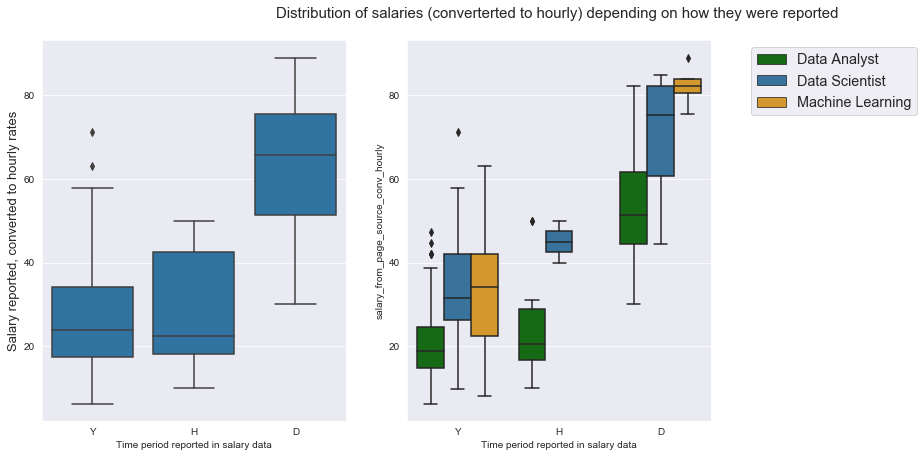

In [6]:
salaries_by_period = salaries_df.loc[~((salaries_df.salary_from_page_source_time_period=='M') ^ (salaries_df.salary_from_page_source_time_period=='W')) ]

fig, ax = plt.subplots(1,2, figsize=(12,7))
plt.title('Distribution of salaries (converterted to hourly) depending on how they were reported \n', fontdict={'size':15})
job_hue_dict={'Data Scientist': 'C0', 'Data Analyst': 'green', 'Machine Learning':'orange'}
job_hue_order = ['Data Analyst', 'Data Scientist', 'Machine Learning']

sns.boxplot(data = salaries_by_period, y  = 'salary_from_page_source_conv_hourly' ,  
            x = 'salary_from_page_source_time_period', ax = ax[0], color='C0')
sns.boxplot(data = salaries_by_period, y  = 'salary_from_page_source_conv_hourly' ,  
            x = 'salary_from_page_source_time_period', hue='job_search_term', ax=ax[1], hue_order=job_hue_order, palette=job_hue_dict, saturation=0.65 )
ax[0].set_ylabel('Salary reported, converted to hourly rates', fontdict={'size':13})
ax[0].set_xlabel('Time period reported in salary data')
ax[1].set_xlabel('Time period reported in salary data')
plt.legend(fontsize='x-large', loc='upper right', bbox_to_anchor=(1.7, 1))
plt.show()

Annual salaries are the largest single block of salaries for all data science jobs. Nevertheless

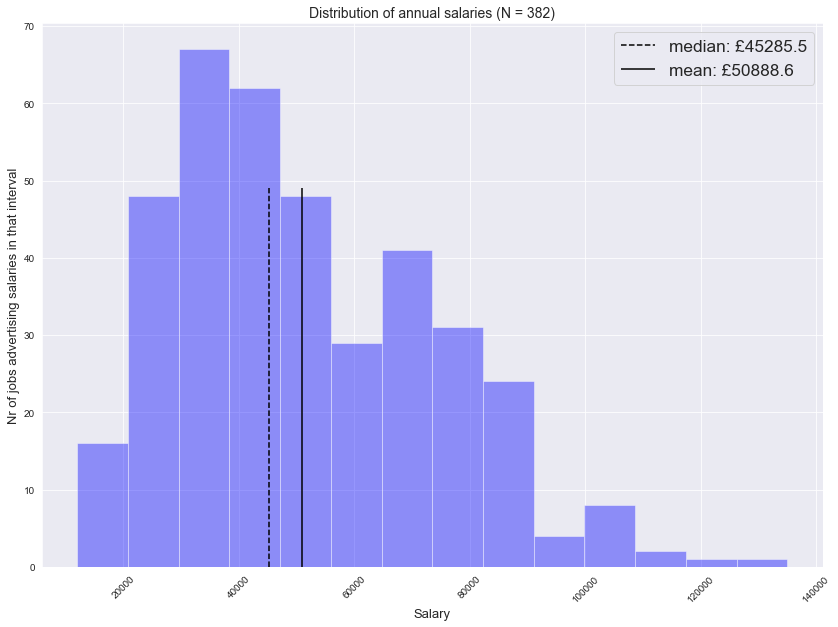

In [7]:
annual_pay = salaries_df.loc[salaries_df.salary_from_page_source_time_period=='Y']

plt.figure(figsize=(14,10))
ax = sns.distplot(annual_pay.salary_from_page_source_as_stated, kde=False, norm_hist=False, color='blue')
plt.title(f'Distribution of annual salaries (N = {len(annual_pay)})', fontdict={'size': 14})
plt.xlabel('Salary', fontdict={'size':13})
plt.ylabel('Nr of jobs advertising salaries in that interval', fontdict={'size':13})
plt.xticks(rotation=45)
median = annual_pay.salary_from_page_source_as_stated.median().round(1)
mean = annual_pay.salary_from_page_source_as_stated.mean().round(1)
plt.vlines(x = median, ymin=0, ymax=49, linestyles='dashed', label=f'median: £{median}')
plt.vlines(x = mean, ymin=0, ymax=49, linestyles='solid', label=f'mean: £{mean}')
plt.legend(fontsize='xx-large')
plt.savefig('fig/dist_annual_salaries.jpg')
plt.show()

In [8]:
num_categ = annual_pay.job_search_term.value_counts()
n_DA = num_categ[0]
n_DS = num_categ[1]
n_ML = num_categ[2]

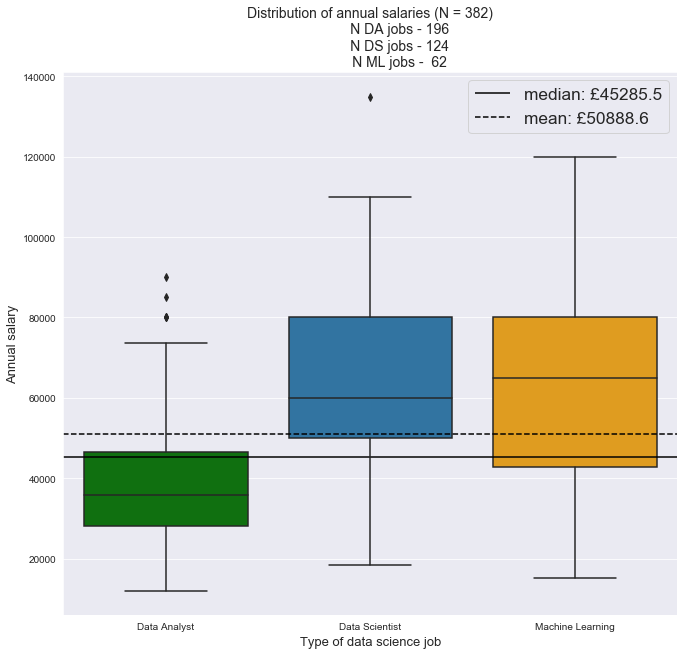

In [10]:
annual_pay = salaries_df.loc[salaries_df.salary_from_page_source_time_period=='Y']

plt.figure(figsize=(11,10))
ax = sns.boxplot(data=annual_pay,y='salary_from_page_source_as_stated', x = 'job_search_term', palette=job_hue_dict, hue_order=job_hue_order)
plt.title(f"""Distribution of annual salaries (N = {len(annual_pay)})
               N DA jobs - {n_DA}
               N DS jobs - {n_DS}
               N ML jobs -  {n_ML}""", fontdict={'size': 14})
plt.xlabel('Type of data science job', fontdict={'size':13})
plt.ylabel('Annual salary', fontdict={'size':13})
plt.xticks(rotation=0)
median = annual_pay.salary_from_page_source_as_stated.median().round(1)
mean = annual_pay.salary_from_page_source_as_stated.mean().round(1)
plt.hlines(y = median , xmin=-.5, xmax=2.5, linestyles='solid', label=f'median: £{median}')
plt.hlines(y = mean, xmin=-.5, xmax=2.5, linestyles='dashed', label=f'mean: £{mean}')
plt.legend(fontsize='xx-large')
plt.savefig('fig/dist_annual_salaries_ALL.jpg')
plt.show()

<div class="alert alert-block alert-info">
There's a very clear trend here that confirms prior suspicions:

DA jobs are not as well paid as ML or DS jobs by quite a margin - the median salary for DS and ML are at least £12k above the median for all data science jobs; <b>DA roles pay about £10k less!</b> If we're aiming to maximise salary, then a recommendation might be to aim for the first 2 categories, however DA jobs are also the most numerous. They might form a reliable fallback for graduates not managing to hit targets for the DS and ML roles. </div>

## 3. What are the main locations that data science roles appear in (other than London) and how does salary vary across them?

Our scraping retrieved 194 different locations (plus "Home Based"), yet it's a very skewed distribution, what with 564 jobs being in London. The vast majority of locations (107) have 1 job post associated with them (e.g. Harrogate, Isle of Wight). One thing that makes the investigation of location harder is the fact that some places included London sub-locations as their location - i.e. Paddington, Hammersmith. These locations thankfully onyl have about 1 job posted so it isn't necessary that we go through the arduous task of recoding all those locations to "London" (not unless we were going to dig deep into the London v country divide). 

Note that although there are 24 jobs put down as Home-based, currently a lot of jobs in the data are "remote" or at least "temporarily remote" so that figure isn't something to use to judge remote working by. Also, there is 1 jobs where the location is "United Kingdom", which can be interpreted as either null value for location or remote. 

In [11]:
# a little bit of additional cleaning to put jobs that posted locs such as "East London" under the "London category"
print(f"Number of unique locations reported : {df.Loc_from_title.nunique()}")
df.Loc_from_title = df.Loc_from_title.apply(fn.is_london)
loc_df = df[['salary_from_page_source_as_stated', 'salary_from_page_source_time_period','job_title', 'Loc_from_title']]
loc_df = loc_df.groupby(['Loc_from_title']).size().sort_values(ascending=False)
loc_df[:20]

Number of unique locations reported : 195


Loc_from_title
London            551
Cambridge          55
Bristol            29
Home Based         24
Manchester         20
Leeds              17
Oxford             15
Glasgow            13
Reading            13
Belfast            13
Birmingham         12
Edinburgh          12
Nottingham         11
Hatfield            6
Slough              6
Southampton         5
Leamington Spa      5
Richmond            5
Cardiff             5
England             5
dtype: int64

* As expected the majority of jobs put London as their location, reflecting the concentration of demand for tech skills in the capital. This is a starker divide than encountered with software developer jobs, which are a bit more evenly spread. 
* Other predictable locations are Cambridge and Oxford, the former more notably so for being a bit of tech magnet. Even so, the numbers are utterly dwarfed by London

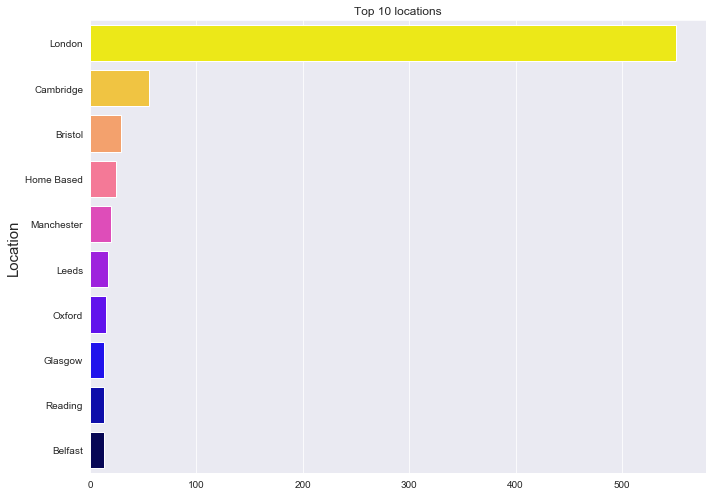

In [12]:
#plotting the nr of jobs by location stated
loc_df = df[['salary_from_page_source_as_stated', 'salary_from_page_source_time_period','job_title', 'Loc_from_title']]
loc_df_gr = loc_df.groupby(['Loc_from_title']).size().sort_values(ascending=False)
top_10 = loc_df_gr[:10]
top_7 = loc_df_gr[:7]
plt.figure(figsize=(10,7))
sns.barplot(y=top_10.index, x=top_10, palette = 'gnuplot2_r', saturation=0.85);
plt.title('Top 10 locations')
plt.ylabel('Location', fontdict={'size':15})
plt.tight_layout()
plt.savefig('fig/top_10_locs.jpg')
plt.show()

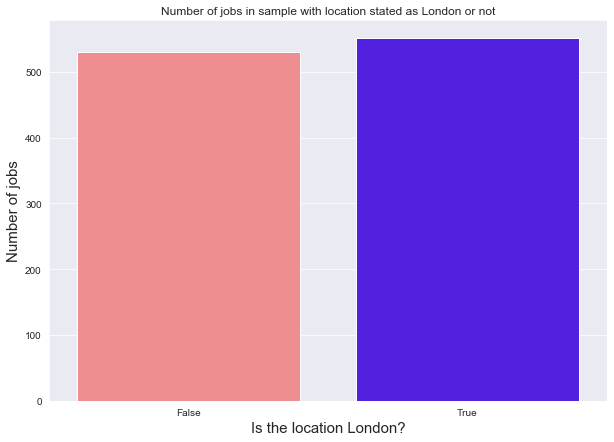

In [13]:
#plotting the nr of jobs by location London vs non-London
loc_df['is_london'] = False
loc_df.loc[loc_df.Loc_from_title =='London' , 'is_london'] = True
is_london_val = loc_df.is_london.value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=is_london_val.index, y=is_london_val.values, palette = 'gnuplot2_r',);
plt.title('Number of jobs in sample with location stated as London or not')
plt.ylabel('Number of jobs', fontdict={'size':15})
plt.xlabel('Is the location London?', fontdict={'size':15})
plt.savefig('fig/ldn_vs_non_ldn.jpg')
plt.show()

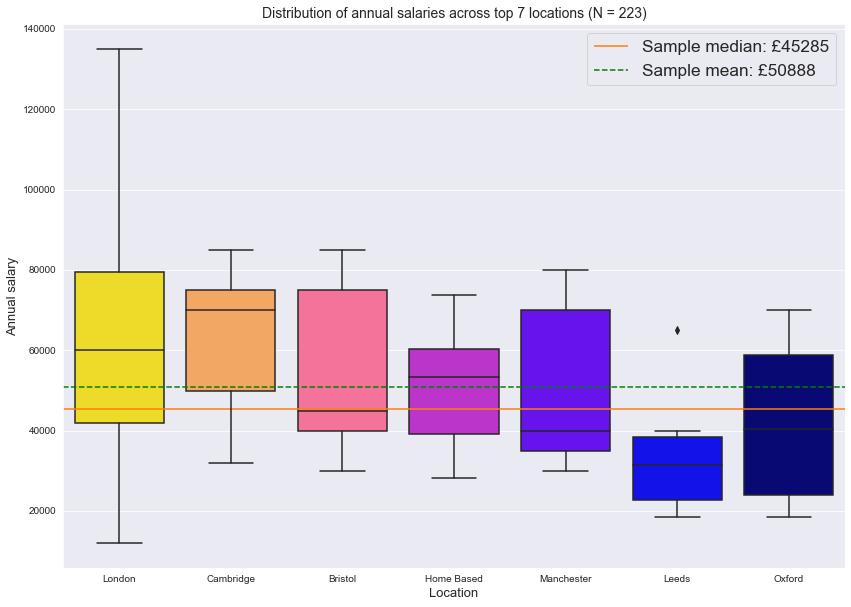

Loc_from_title
London        551
Cambridge      55
Bristol        29
Home Based     24
Manchester     20
Leeds          17
Oxford         15
dtype: int64


In [14]:
plt.figure(figsize=(14,10))
top_7_sal = annual_pay.loc[annual_pay.Loc_from_title.isin(top_7.index)]
ax = sns.boxplot(data = top_7_sal, y ='salary_from_page_source_as_stated', x='Loc_from_title', order=top_7.index.to_list(), palette='gnuplot2_r', saturation=0.85)
plt.title(f'Distribution of annual salaries across top 7 locations (N = {len(top_7_sal)})', fontdict={'size': 14})
plt.xlabel('Location', fontdict={'size':13})
plt.ylabel('Annual salary', fontdict={'size':13})
sample_median = int(annual_pay.salary_from_page_source_as_stated.median())
sample_mean = int(annual_pay.salary_from_page_source_as_stated.mean())
# ONS_mean_subsect62 = int(sector_avg['2019'][0])
plt.hlines(y = sample_median, xmin=-0.5, xmax=6.5 ,linestyles='solid', colors='C1' ,label=f'Sample median: £{sample_median}')
plt.hlines(y = sample_mean, xmin=-0.5, xmax=6.5 ,linestyles='dashed', colors='green', label=f'Sample mean: £{sample_mean}')
# plt.hlines(y = ONS_mean_subsect62, xmin=-0.5, xmax=9.5 ,linestyles='dashed', colors='r', label=f'ONS National mean (2019) Programming: £{ONS_mean_subsect62}')
plt.legend(fontsize='xx-large')
plt.savefig('fig/dist_annual_salaries_by_loc.jpg')
plt.show()
print(top_7)

Below we can see how these annual salaries vary by location. London and Cambridge's median salaries are well above the total sample mean. This is to be expected for London given the "London allowance" (it may not be official in the tech sector, but it's generally recognised that jobs there do have to pay more if they are to expect employees to be able to live in the capital). This is slightly surprising for Cambridge -  the data reflects greater tech opportunities opening up in Cambridge compared to its typical rival in all other matters, Oxford, with the former becoming increasingly known as the ["Silicon Fen"](https://en.wikipedia.org/wiki/Silicon_Fen) (or Cambridge Cluster). 

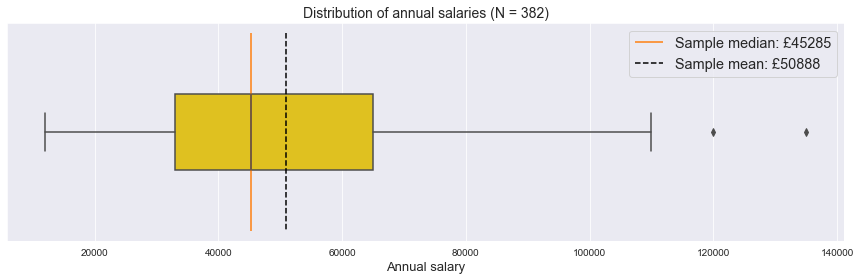

In [15]:
plt.figure(figsize=(15,4))
ax = sns.boxplot(data = annual_pay, x ='salary_from_page_source_as_stated', color='gold', )
plt.title(f'Distribution of annual salaries (N = {len(annual_pay)})', fontdict={'size': 14})
plt.xlabel('Annual salary', fontdict={'size':13})
sample_median = int(annual_pay.salary_from_page_source_as_stated.median())
sample_mean = int(annual_pay.salary_from_page_source_as_stated.mean())
# ONS_mean_subsect62 = int(sector_avg['2019'][0])
plt.vlines(x = sample_median, ymin=-1.05, ymax=1.05 ,linestyles='solid', colors='C1' ,label=f'Sample median: £{sample_median}', )
plt.vlines(x = sample_mean, ymin=-1.05, ymax=1.05,linestyles='dashed', label=f'Sample mean: £{sample_mean}')
# plt.vlines(x = ONS_mean_subsect62, ymin=-1.05, ymax=1.05 ,linestyles='dashed', colors='r', label=f'ONS National mean (2019) Computer \n Programming and related: £{ONS_mean_subsect62}')
plt.legend(fontsize='x-large', loc='upper right', )
plt.savefig('fig/distribution_annual.jpg')
plt.show()

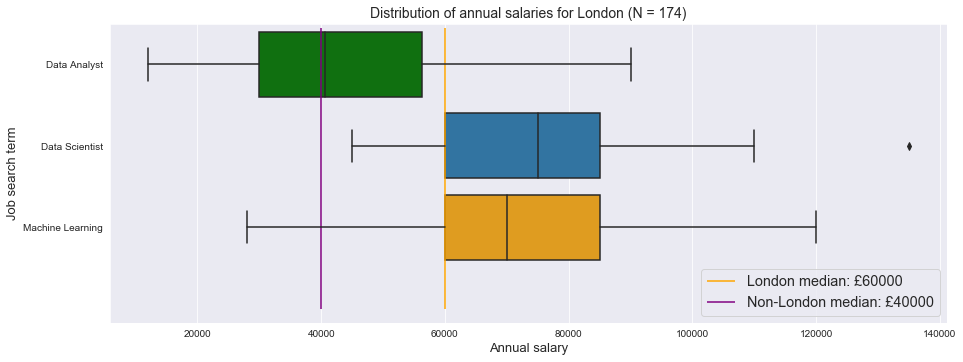

Data Analyst        76
Data Scientist      65
Machine Learning    33
Name: job_search_term, dtype: int64


In [16]:
plt.figure(figsize=(15,5.5))
ldn_annual = annual_pay.loc[annual_pay.Loc_from_title=='London']
non_ldn_annual  = annual_pay.loc[~(annual_pay.Loc_from_title=='London')]
ax = sns.boxplot(data = ldn_annual, x ='salary_from_page_source_as_stated' , y = 'job_search_term',  palette=job_hue_dict)
#                 hue=job_hue_dict, hue_order=job_hue_order)
plt.title(f'Distribution of annual salaries for London (N = {len(ldn_annual)})', fontdict={'size': 14})
plt.xlabel('Annual salary', fontdict={'size':13})
plt.ylabel('Job search term', fontdict={'size':13})
ldn_median = int(ldn_annual.salary_from_page_source_as_stated.median())
ldn_mean = int(ldn_annual.salary_from_page_source_as_stated.mean())
non_ldn_median = int(non_ldn_annual.salary_from_page_source_as_stated.median())
non_ldn_mean = int(non_ldn_annual.salary_from_page_source_as_stated.mean())

# ONS_mean_subsect62 = int(sector_avg['2019'][0])
plt.vlines(x = ldn_median, ymin=-0.45, ymax=3. ,linestyles='solid', colors='orange' ,label=f'London median: £{ldn_median}')
# plt.vlines(x = ldn_mean, ymin=-0.45, ymax=3.,linestyles='dashed', colors = 'C4', label=f'London mean: £{ldn_mean}')
plt.vlines(x = non_ldn_median, ymin=-0.45, ymax=3. ,linestyles='solid', colors='purple' ,label=f'Non-London median: £{non_ldn_median}')
# plt.vlines(x = non_ldn_mean, ymin=-0.45, ymax=3.,linestyles='dashed', colors='C6', label=f'Non-London mean: £{non_ldn_mean}')
# plt.vlines(x = ONS_mean_subsect62, ymin=-1.05, ymax=1.05 ,linestyles='dashed', colors='r', label=f'ONS National mean (2019) Computer \n Programming and related: £{ONS_mean_subsect62}')
plt.legend(fontsize='x-large', loc='lower right', )
plt.savefig('fig/distribution_annual_London.jpg')
plt.show()
print(ldn_annual.job_search_term.value_counts())

Although DA jobs are slightly less renumerative than the other two groups, they're not trailing far behind the sample average - only by about ~£8k. DA jobs return as much money of data science jobs generally do outside of London, on average. 

There's no doubt that you're very likely to be paid far more in a DS or ML in London than outside, and by quite some way. 

#### Quick check for remote working

Using regex (function available in functions.py), let's try to see if we can find mentions of working remotely. For this, my function first greedily searches for terms in the list below. When I pass it a list within that list, it will do the search for every single variation in that sublist, create a column of values for how many times that term was mentioned, then add all of the columns into 1 single column, which will include the name of the first variable in the sub-list (in this case 'Remote'). 

For instance, if we just had the first 3 terms in the sublist, the function would create three columns - for how many times 'Remote', 'remote' and 'Temporarily remote' were mentioned respectively; then it would sum all the values across those columns and return a single column. 

In [17]:
remote_str_lst = [['Remote', 'remote', 'Temporarily remote', 'remote due to', 'due to covid',
                   'work from home', 'WFH', 'Work from home', 'work remotely', 'wfh', 'home-based',
                   'Home-based', 'Home based', 'work remote', 'work remotely',]]

remote_data = fn.get_pattern_count_and_store(df, remote_str_lst,  columns=['job_descr', 'job_title'])
remote_data['mentions_Remote_bool'] = 0
remote_data.loc[remote_data.num_mention_TOTAL_Remote!=0, 'mentions_Remote_bool'] = 1

remote_data.mentions_Remote_bool.value_counts()

0    1013
1      69
Name: mentions_Remote_bool, dtype: int64

<div class="alert alert-block alert-warning">
Surprisingly, there is very little mention of remote work across the job descriptions, even with all those variations. <b>However, we shouldn't leap to any conclusions </b> since we must bear in mind the data collection process - there's a chance that a tag for remote work was present in other job posts, but kept as a separate html element (e.g. tucked above the job role title), and my webscraper may have missed it. If I really wanted to further investigate and make a proper statement about the presence of remote work, I'd have to go and upgrade the scraping tool to retrieve that info from Indeed.co.uk.

### Future action 1: Improve webscraper to accurtely identify presence of "remote working" tag
 </div>

## 4. What are some of the most frequent words mentioned in the job titles?

When we look at the top 20 terms and 20 bigrams (pairs of words) that appear across all the titles (1082), what do we see? This can give us a quick indication of where the actual market is needing data scientists and what skills they have to focus on.

In [18]:
%%capture
#How many terms to include
N=20

# putting common title words into stopwords - given what we have searched already, including words such as "machine" and "analyst" would not be useful to us
# this function also includes general English stopwords such "and", "this", "now"
title_sw = fn.gen_stopwords(['data', 'scientist', 'machine', 'ML', 'analyst', 'learning', 'analytics', 'analyst'])
titles = df.job_title
title_df = fn.get_top_n_terms(titles, N, stop_words_list=title_sw)
title_df_bigram = fn.get_top_n_terms(titles, N, stop_words_list=title_sw , ngram_number=2)

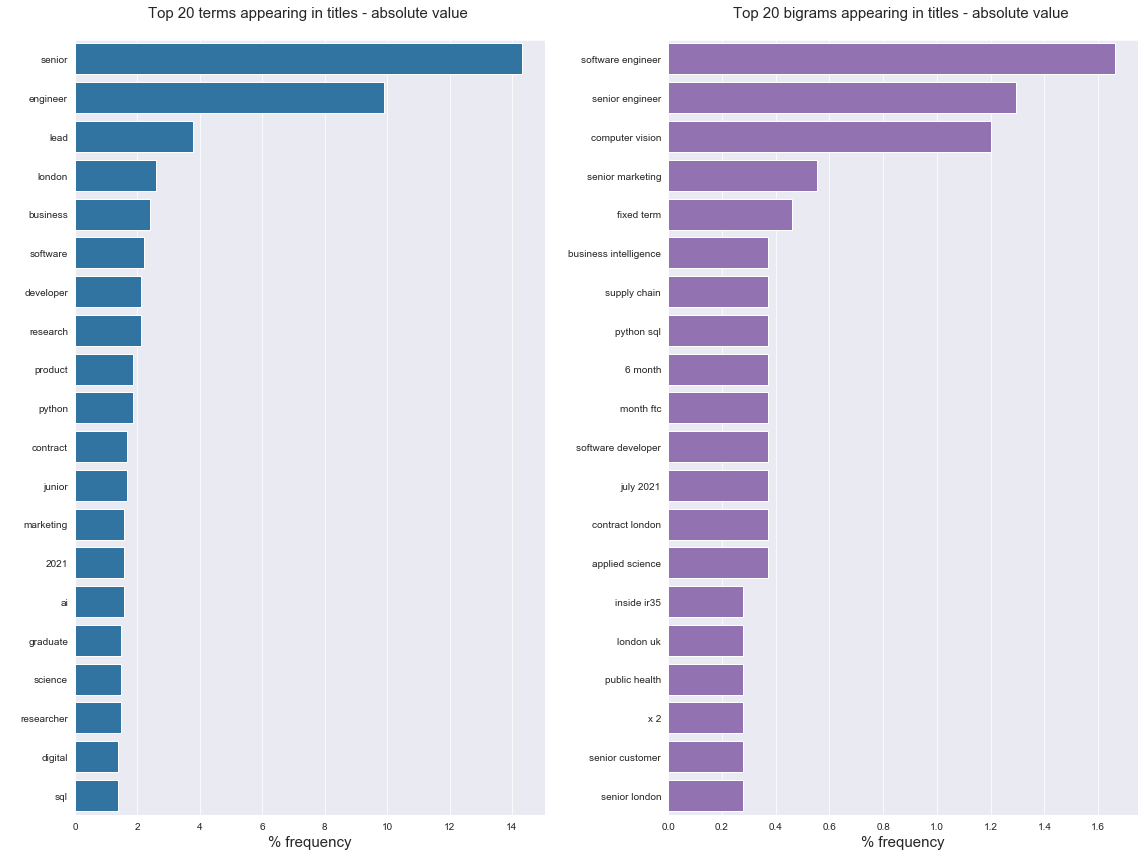

In [19]:
# plt.figure(figsize=(20,20))
fig, ax = plt.subplots(1,2, figsize=(16,12),  )

ax[0].set_title('Top {} terms appearing in titles - absolute value \n'.format(N), fontdict={'size':15})
ax[1].set_title('Top {} bigrams appearing in titles - absolute value \n'.format(N), fontdict={'size':15})
plt.rcParams['ytick.labelsize'] = 16
sns.barplot(data= title_df, x='norm_frequency', y='terms', ax=ax[0], color='C0',);
sns.barplot(data= title_df_bigram, x='norm_frequency', y='terms', ax=ax[1], color='C4');
ax[0].set_ylabel(' ')
ax[1].set_ylabel(' ')
ax[0].set_xlabel('% frequency', fontdict={'size':15})
ax[1].set_xlabel('% frequency', fontdict={'size':15})
plt.tight_layout()
plt.savefig('fig/title_uni_and_bigrams.jpg')
plt.show()


<div class="alert alert-block alert-info">
    
* About 14% of jobs are "senior" roles, hence looking for more experienced data scientists. This does not bode well for recent bootcamp graduates. 'Junior' roles make up less than 2% of the sample. While it is true that titles that do not mention either will lie on a spectrum of experience between those two, it's concerning that 
* There's about 10% of roles that are looking for an engineer role, which could either be 'machine learning engineer' (most of the occurences) or 'software engineer' (~19 roles in all).
* There's very few titles explicitly mentioning a language (e..g Python is mentioned in less than 2% of titles. To assess any trends in language we'll have to search through the job descriptions. 
* Very few jobs advertise by specific area of expertise it seems (e.g. "Natural Language processing", "public health"). The most frequent case of data science specific  expertise being demanded are roles focussed on Computer Vision (13 jobs). Perhaps this would indicate that most roles look for a blend of different skills, but aren't looking for one single specialty area. This is encouraging for us since our graduates will have some flexibility in what skills to use for leverage. 
</div>



If our graduates search the job market and are intimidated by the greater amount of senior vs junior roles we should alert them to the important fact that there will be roles not advertising explicitly as Junior which will still be more in line with their level of experience AND that 

## 5. Which programming languages are in greatest demand?

In order to find out which programming languages are in demand, we are going to have to explicitly search for each one via regex. The issue with that is knowing which ones to pick in advance - luckily we have a stack of languages we either already teach or whose popularity we are already are aware of based on other research. 

We could also use Term-Frequency Inverse Document Frequency (TFIDF) to see what the highest scoring words are in terms of 'importance'. This approach has the advantage over Frequency Distributions of weighing down words that appear frequently across all documents (which could range from "agile" to "processes"). I've done so below, but sadly it hasn't revealed anything more than the python and SQL that we expected. 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words=fn.gen_stopwords(), min_df=0.25, max_df=0.8, smooth_idf=False)

transformed_descr = tfidf_vect.fit_transform(df.job_descr.to_list())
feature_names = tfidf_vect.get_feature_names()


In [21]:
td_mat = pd.DataFrame(data=transformed_descr.toarray(), columns=feature_names)
ranked_terms = td_mat.sum().sort_values(ascending=False)
ranked_terms[:30]

business       129.778584
working        106.131662
skill           90.723476
analysis        85.662271
customer        84.114531
client          81.988172
product         81.066081
project         76.227279
opportunity     75.191902
model           72.056953
development     71.481700
new             69.618858
support         69.116567
using           66.956476
research        66.448994
technology      66.138021
people          64.779318
within          63.537677
ability         63.524293
solution        62.531810
management      62.459698
python          61.143233
strong          60.421099
tool            60.339545
service         58.814355
problem         58.721663
technical       58.197385
time            57.815111
insight         57.673420
sql             57.366709
dtype: float64

### Searching explicitly for languages and different software

In the cells below I'll be feeding in a list of different languges, domains and software and storing the results as new columns in the dataframe. 

For thinking of the most likely languages to appear, I used my own experience of the field, the Q3 2020 Global Developer Population Calculator (available online through [SlashData](https://dashboard.slashdata.co/?utm_source=SlashData_Website&utm_medium=Header_Menu&utm_campaign=Calculator), and an Analytics Vidhya [article](https://www.analyticsvidhya.com/blog/2020/09/different-nosql-databases-every-data-scientist-must-know/) on the most popular NoSQL databases. 

Some of my inclusions may be a bit odd for data science jobs (e.g. Javascript and Ruby), however I have definitely witnessed the mention of the former in a DS role before, and it doesn't cost us anything to search for more general developer languages too. 

In [22]:
# defining the list of programming languages to search for 
# when using the function in the next cell, all single string elements in list will form one column
# for every sub-list of n elements, n different columns will be formed and then added up for a final total
list_languages = [['Python', 'python'], ['R', 'R-language', 'R-programming'], # the 2 standard data science languages we'd expect
                  ['Java', 'JDK', 'SE7+'], 'C++','C#',                   # since some data science positions require familiarity with software dev languages
                  'Kotlin', 'PHP', ['JavaScript', 'Javascript'], 'Swift', 'Ruby', # popular programming languages with devs acc to SlashData report - including them just incase
                  'Objective C', 'Dart', 'Lua', 'Rust', 'Embedded C', ['.NET', '.net'], 
                  ['Shell', 'Shell script', 'Shell scripting', 'Bash',
                  'shell', 'shell script', 'shell scripting', 'bash'],
                   'Scala', 'Perl',      # some languages less likely to come up
                  ['SQL', 'PostgreSQL', 'postgreSQL', 'MySQL', 'MSSQL', 'SQLite',],  # looking for mentions of SQL
                  ['NoSQL', 'MongoDB','mongoDB', 'mongodb', 'Cassandra', 
                   'cassandra','Elasticsearch','elasticsearch','DynamoDB', 'HBase', 'hbase'], # important to look for the mentions of Not Only SQL type dbs
                  ['AWS', 'Amazon Web','Sagemaker', 'SageMaker'],
                  ['Azure', 'Microsoft cloud'],
                  ['GCP', 'Google Cloud'],
                  'Docker', 'Kubernetes',
                  ['Microsoft excel', 'Excel', 'Office365'],
                  ['Deep learning', 'deep learning', 'Deep Learning', 'Neural networks', 
                   'neural nets','Neural Nets', 'neural networks','backpropagation', 'Backpropagation',
                  'ANN', 'ANNs'],
                  ['NLP', 'natural language', 'language processing', 'text processing','text analytics', 'text analysis'],
                  ['cloud computing','Cloud computing', 'cloud services', 'cloud platforms',],
                  ['statistics', 'Statistics', 'statistical','Statistical','regression', 
                   'Regression','stats', 'statistician', 'Stats', 'Statistician'],
                  ['Visualisation','data viz', 'visualisation','visualization','Visualization', 'visuals', 
                   'plotly', 'seaborn', 'matplotlib'],
                  ['Dashboard','dashboard', 'dashboards', 'dashboarding', 'Tableau', 'Shiny', 'PowerBI', 'plotly dash'],
                  ['classifiers', 'Classification', 'classification', 'KNNs','KNN','Logistic Regression',
                   'Support Vector', 'support vector', 'Decision Trees', 'Random Forest', 'XGBoost',],
                  ['computer vision', 'image recognition', 'Computer vision', 'OpenCV','image classification',
                   'CNN', 'Convolutional Neural','convolutional neural', 'Convolutional neural'],
                  ['Version control', 'version control', 'git', 'Git', 'Github', 'GitHub'],
                  ['cluster computing','Spark', 'spark', 'distributed processing', 'Hadoop', 'hadoop', 'RDD', 'RDDs', 'HDFS','MapReduce', 'mapreduce', 'Mapreduce']
                 ] 

In [23]:
# this cell will take a while
new_df = fn.get_pattern_count_and_store(df, list_languages, columns=['job_descr', 'job_title'])

In [24]:
new_df.tail()

,company,job_title,job_descr,time_of_scrape,job_search_term,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews,Loc_from_title,...,num_mention_TOTAL_Deep learning,num_mention_TOTAL_NLP,num_mention_TOTAL_cloud computing,num_mention_TOTAL_statistics,num_mention_TOTAL_Visualisation,num_mention_TOTAL_Dashboard,num_mention_TOTAL_classifiers,num_mention_TOTAL_computer vision,num_mention_TOTAL_Version control,num_mention_TOTAL_cluster computing
1077,Ocado Group,Machine Learning Engineer,We are on a mission to transform the future of...,Tue Nov 24 14:16:42 2020,Machine Learning,NaN,NaN,NaN,1022.0,Hatfield,...,0,0,0,0,0,0,0,0,0,0
1078,Greensill,Machine Learning Technical Specialist,Role Purpose Implement financial project in a ...,Tue Nov 24 14:16:48 2020,Machine Learning,NaN,NaN,NaN,NaN,Warrington,...,0,0,0,0,0,0,0,0,0,0
1079,TikTok,Graduate Machine Learning Engineer (Trust and ...,Responsibilities TikTok is the leading destina...,Tue Nov 24 14:16:53 2020,Machine Learning,NaN,NaN,NaN,11.0,London,...,0,6,0,0,0,0,0,0,0,0
1080,Understanding Recruitment,"Machine Learning Engineer (Data Scientist, NLP...",As a Machine Learning Engineer Data Scientist ...,Tue Nov 24 14:16:59 2020,Machine Learning,65000.0,34.25,Y,NaN,London,...,0,36,0,0,0,0,0,0,0,0
1081,EVERYANGLE,Senior Machine Learning Engineer,EVERYANGLE is a headquartered in Dublin Irelan...,Tue Nov 24 14:17:05 2020,Machine Learning,55000.0,28.98,Y,NaN,Home Based,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# creating 2 sorted series of language mention values, one ranked by total mentions, other just by binary counts (i.e. if a post mentions SQL 5 times, it's counted as one)
#sectioning off the langauge count data
language_counts = new_df.iloc[:,12:].sum(0, numeric_only=True)
#sorting dataframe
language_counts.sort_values(ascending=False, inplace=True)
#sectioning off a new dataframe for the binary column data
language_single_counts_ = new_df.iloc[:,12:]
#change all non-zero to 1 in binary dataframe
language_single_counts_ = language_single_counts_.applymap(lambda x : 1 if (x>0) else 0,)
#creating a separate pandas series for ranking comparison
language_counts_uniq = language_single_counts_.sum(0, numeric_only=True)
language_counts_uniq.sort_values(ascending=False, inplace=True)
i, color_palette_dict = 0,{}
#assigning a unique colour to each different column value, (e.g. "SQL - C1 (orange)"
#so that bars are more easily comparable across the 2 charts)
for lang in [x.replace('num_mention_TOTAL_', '') for x in language_counts_uniq.index]:
    color_palette_dict[lang] = f'C{i}'
    i= i+1
#cutting off values of zero from the 2 rankes series    
language_counts_disp = language_counts.loc[language_counts!=0]
language_counts_uniq_disp = language_counts_uniq.loc[language_counts_uniq!=0]

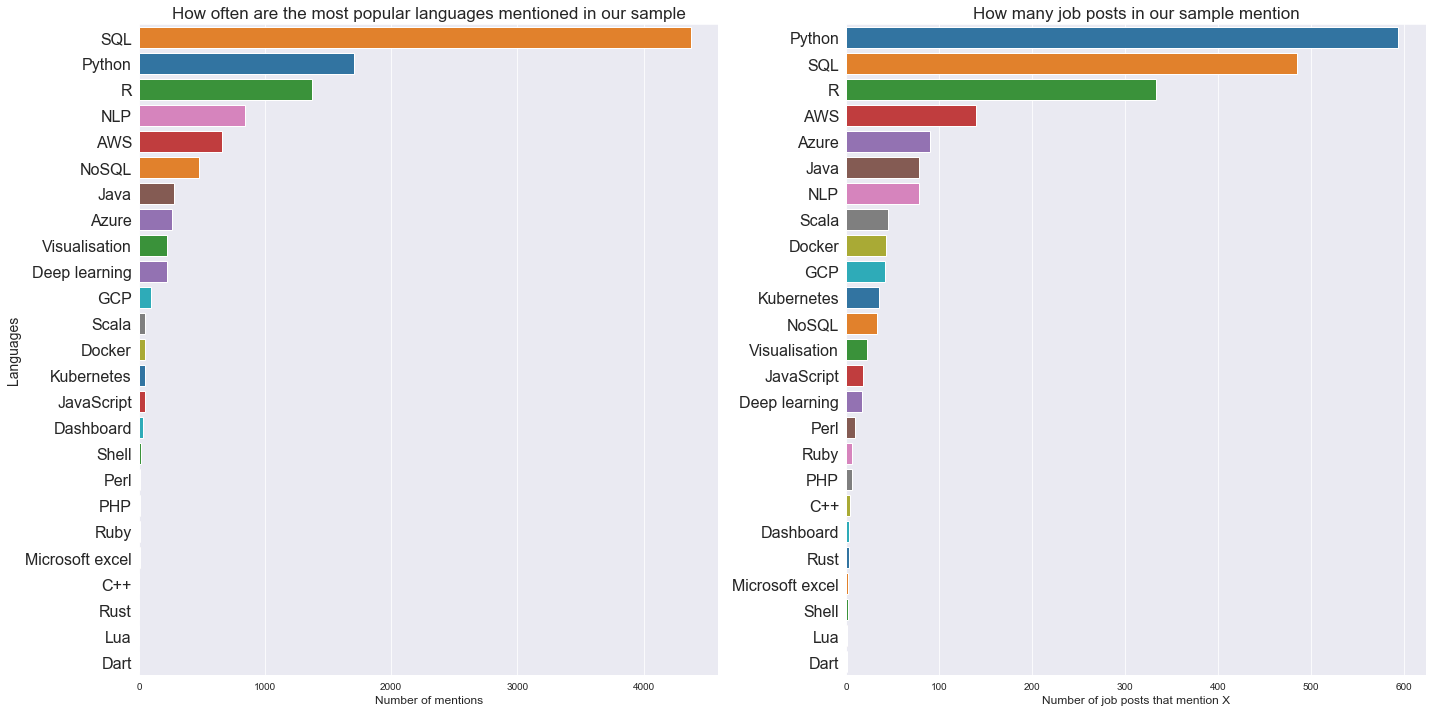

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
#plotting the total frequencies of mentions in the left-hand barchart
sns.barplot(y = [x.replace('num_mention_TOTAL_', '') for x in language_counts_disp.index], x =language_counts_disp.values, orient='h', ax=ax[0], palette=color_palette_dict)
ax[0].set_title('How often are the most popular languages mentioned in our sample', fontdict={'size':17})
ax[0].set_xlabel('Number of mentions', fontdict={'size':12})
ax[0].set_ylabel('Languages', fontdict={'size':14})

#plotting the binary mentions - so the bar chart where even if SQL gets mentioned 5 times, it counts as 1 mention. This is a more accurate method
sns.barplot(y = [x.replace('num_mention_TOTAL_', '') for x in language_counts_uniq_disp.index], x =language_counts_uniq_disp.values, orient='h', ax=ax[1], palette=color_palette_dict)
ax[1].set_title('How many job posts in our sample mention', fontdict={'size':17})
ax[1].set_xlabel('Number of job posts that mention X', fontdict={'size':12})
ax[1].set_ylabel('', fontdict={'size':14})
plt.tight_layout()
plt.savefig('fig/programming_languages.jpg')
plt.show()

<div class="alert alert-block alert-warning">
   
### Important
    
Please note that the barchart on the left is the results of a very <i>greedy</i> searching mechanism - because my main aim was to capture all job posts that made mention of any variation of a language or skill, my function didn't pay much heed to duplication within the same article. This is partially because it doens't matter as much (if a job mentions 'Python' twice, that doesn't suddenly make Python twice as important, what matters is if it's mentioning it <b>at all</b>! 
    
For example: SQL was probably mentioned in a variety of different ways in any job post:
> "We require experience of PostgreSQL, MySQL or Microsoft SQL Server"
    
Although it may be useful to know that SQL was mentioned 3 times in some form or another, it makes it very difficult to compare across job posts. If we simply have data where a 0 means SQL was not mentioned and 1 means the opposite, then we're capturing its presence in a job post, which is more relevant to our goals.
    
SQL dominated the raw count frequency, aided by the variety of flavours there exist, but when going by single mention, Python is definitely more important. The barchart on the left is one of the most important products of this project, generating the following takeaway:
</div>

<div class="alert alert-block alert-success">

# Recommendations:

* Python and SQL are by far the most in-demand languages / skill in the data science job market. These should form the core of our programming content (if they don't already).
* Although NoSQL is an important concept our graduates should be familiar with, it is still over-shadowed massively by SQL - we should aim to familiarise learners with NoSQL structures, but not go to the same depth or practice that we do with SQL.
* Use of cloud platforms and computing should be included as its own module or integrated across curriculum, with a heavy lean towards Amazon Web Services.
* As much prominence as deep learning has gained recently, it's really not what we should be focussing on -it occurs in <b>less than 5% of job posts</b> (at least, explicitly). New data science learners may be enthusiastic about it, but we should be hesitant to focus on it: either remove it from our curriculum or make it optional. 
* A number of sub-modules or lessons can be dedicated to the extra items that might give our grads the edge in ~ 5-10% of jobs: NLP, Scala and Docker. 
    * further research needs to be done into the high number of mentions of Java - this could be more prominent in the ML groups since Java allows for optimising code and more extensive application of machine learning products. 
    
</div>

In [27]:
df.job_search_term.value_counts()

Data Analyst        501
Data Scientist      384
Machine Learning    197
Name: job_search_term, dtype: int64

In [28]:
lst_cols_for_plot = list(language_counts_uniq_disp.index[:10])
lst_cols_for_plot.append('job_search_term')

In [29]:
mentions_by_job_type = pd.concat([language_single_counts_, new_df[['job_search_term']] ], axis=1)

In [30]:
mentions_by_job_type_main = mentions_by_job_type.drop(columns = [x for x in list(mentions_by_job_type.columns) if x not in lst_cols_for_plot])
mentions_by_job_type_main.head(3)

,num_mention_TOTAL_Python,num_mention_TOTAL_R,num_mention_TOTAL_Java,num_mention_TOTAL_Scala,num_mention_TOTAL_SQL,num_mention_TOTAL_AWS,num_mention_TOTAL_Azure,num_mention_TOTAL_GCP,num_mention_TOTAL_Docker,num_mention_TOTAL_NLP,job_search_term
0,0,0,0,0,1,0,0,0,0,0,Data Analyst
1,0,0,0,0,1,0,0,0,0,0,Data Analyst
2,0,0,0,0,0,0,0,0,0,0,Data Analyst


In [31]:
mentions_by_job_group = mentions_by_job_type_main.groupby(['job_search_term']).sum()
mentions_by_job_group

,num_mention_TOTAL_Python,num_mention_TOTAL_R,num_mention_TOTAL_Java,num_mention_TOTAL_Scala,num_mention_TOTAL_SQL,num_mention_TOTAL_AWS,num_mention_TOTAL_Azure,num_mention_TOTAL_GCP,num_mention_TOTAL_Docker,num_mention_TOTAL_NLP
job_search_term,,,,,,,,,,
Data Analyst,136,104,3,1,266,21,31,6,0,5
Data Scientist,303,183,38,31,189,68,48,23,18,46
Machine Learning,155,46,37,13,30,51,11,13,25,27


#### Testing data manipulation and groupbys

In [32]:
29/197 * 100

14.720812182741117

In [33]:
np.sum(mentions_by_job_type_main.num_mention_TOTAL_Python) == np.sum(mentions_by_job_group.num_mention_TOTAL_Python)

True

In [34]:
mentions_by_job_group['TOTAL'] = [501, 384, 197]
mentions_agg = mentions_by_job_group.agg([lambda x: 100*x/(x.max())], axis=1).reset_index().drop(columns=['level_1', 'TOTAL'],)
mentions_agg

,level_0,num_mention_TOTAL_Python,num_mention_TOTAL_R,num_mention_TOTAL_Java,num_mention_TOTAL_Scala,num_mention_TOTAL_SQL,num_mention_TOTAL_AWS,num_mention_TOTAL_Azure,num_mention_TOTAL_GCP,num_mention_TOTAL_Docker,num_mention_TOTAL_NLP
0,Data Analyst,27.145709,20.758483,0.598802,0.199601,53.093812,4.191617,6.187625,1.197605,0.000000,0.998004
1,Data Scientist,78.906250,47.656250,9.895833,8.072917,49.218750,17.708333,12.500000,5.989583,4.687500,11.979167
2,Machine Learning,78.680203,23.350254,18.781726,6.598985,15.228426,25.888325,5.583756,6.598985,12.690355,13.705584


In [39]:
mentions_agg_melt = pd.melt(mentions_agg, id_vars='level_0',)
mentions_agg_melt.variable = mentions_agg_melt.variable.apply(lambda x : x.replace('num_mention_TOTAL_', ''))

mentions_agg_melt.head()

,level_0,variable,value
0,Data Analyst,Python,27.145709
1,Data Scientist,Python,78.906250
2,Machine Learning,Python,78.680203
3,Data Analyst,R,20.758483
4,Data Scientist,R,47.656250


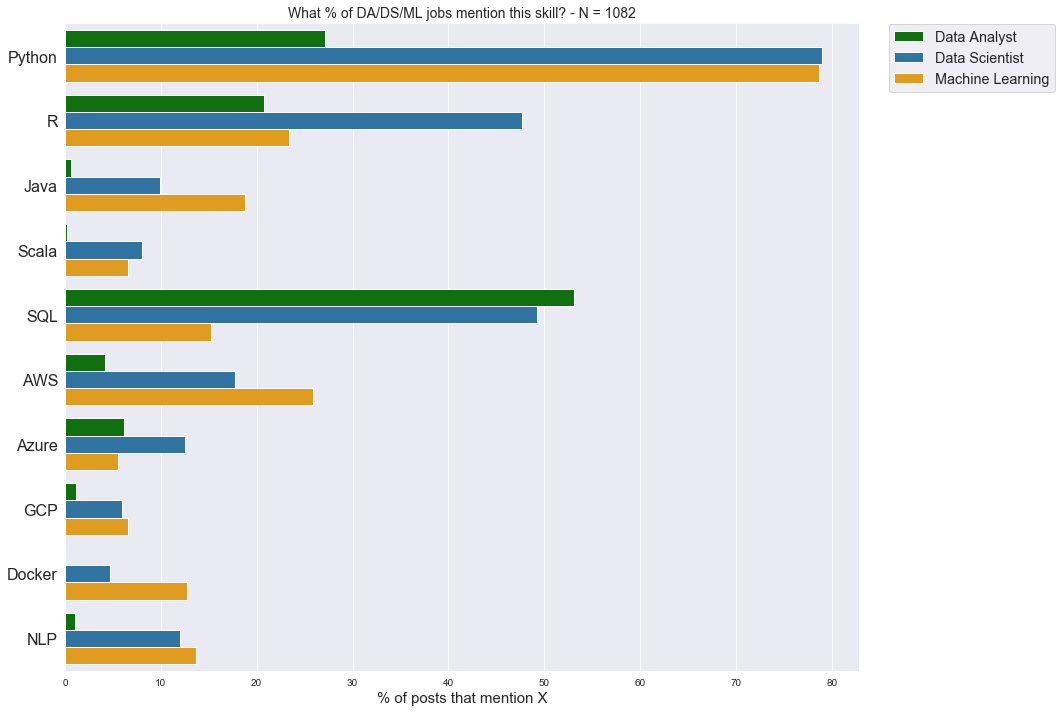

In [43]:
plt.figure(figsize=(15,10))
sns.barplot(data = mentions_agg_melt,y='variable', x='value', hue='level_0', palette=job_hue_dict, hue_order=job_hue_order,)
plt.legend(fontsize='x-large', loc='upper right', bbox_to_anchor=(1.255, 1.01))
plt.title(f'What % of DA/DS/ML jobs mention this skill? - N = 1082', fontdict={'size':14})
plt.xlabel('% of posts that mention X', fontdict={'size':15})
plt.ylabel('')
plt.tight_layout()
plt.savefig('fig/percentage_mentions_by_group.jpg')
plt.show()

<div class="alert alert-block alert-info">

## Insights:
    
* There's a strong gap in skills requireed between DA roles on the one hand and DS and ML roles on the other. This corroborates general knowledge of how those roles function. 
* If we have learners wanting to specialise towards the three different pathways, then we can advise them what kind of skills they need for work on for each one: e.g. stronger SQL for prospective DA; concentrate on AWS for ML-centric data scientists.

</div>

<div class="alert alert-block alert-success">

## Recommendation:
    
* Towards the end of our course, create 'Career Profiles' that learners can gravitate towards depending on the kind of work they would prefer doing. Those that want heavier computational work (so drawn towards ML type jobs), can attend classes on Docker, Java and AWS. Those drawn more towards analytics can spend more time refining their SQL and other relevant skills. 

</div>

### Developing a tool for salary prediction

Goal:
Select a number of important features to use as predictors in a linear regression model, with the target variable of converted hourly salary. 
* going for roughly minimimum of 10 data points per variable, so if we have 10 independent vars in total, then we need to have at least 100 points in the training data.
* Changed Location variable to in_London since that's the only location we'd expect to massively affect the price. 
* Only using annual salary data (382 data points) since that's the most reliable, otherwise I suspect our residuals will be far more skewed
* Running tfidf on title to extract really meaningful terms that we can include as additional features

* Removing outliers in price data, for the purpose of linear regression

In [36]:
# merging all cloud service columns into one
language_single_counts_['mentions_Cloud_services'] = 0
language_single_counts_.loc[((language_single_counts_['num_mention_TOTAL_AWS'] ==1 )|
                            (language_single_counts_['num_mention_TOTAL_Azure'] ==1) |
                            (language_single_counts_['num_mention_TOTAL_GCP'] ==1 )),'mentions_Cloud_services'] = 1
language_single_counts_.columns = [x.replace('num_mention_TOTAL_', 'mentions_') for x in language_single_counts_.columns]
cols_of_interest = ['mentions_'+x for x in ['Python', 'Java', 'R', 'Cloud_services', 'SQL',]]
skills_of_interest = language_single_counts_[cols_of_interest ]
skills_of_interest.head(3)

,mentions_Python,mentions_Java,mentions_R,mentions_Cloud_services,mentions_SQL
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082 entries, 0 to 1081
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   company                              1082 non-null   object 
 1   job_title                            1082 non-null   object 
 2   job_descr                            1082 non-null   object 
 3   time_of_scrape                       1082 non-null   object 
 4   job_search_term                      1082 non-null   object 
 5   salary_from_page_source_as_stated    449 non-null    float64
 6   salary_from_page_source_conv_hourly  448 non-null    float64
 7   salary_from_page_source_time_period  448 non-null    object 
 8   Num_reviews                          573 non-null    float64
 9   Loc_from_title                       1082 non-null   object 
 10  date                                 1082 non-null   object 
 11  states_salary                 

In [38]:
# analytic_df = df[['salary_from_page_source_conv_hourly', 'salary_from_page_source_time_period', 'job_title']].join(skills_of_interest,)
analytic_df = df[['salary_from_page_source_as_stated', 'salary_from_page_source_time_period', 'job_title']].join(skills_of_interest,)

analytic_df = analytic_df.loc[(analytic_df['salary_from_page_source_time_period']=='Y')]
analytic_df = analytic_df.drop(columns=['salary_from_page_source_time_period'])
analytic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 0 to 1081
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   salary_from_page_source_as_stated  382 non-null    float64
 1   job_title                          382 non-null    object 
 2   mentions_Python                    382 non-null    int64  
 3   mentions_Java                      382 non-null    int64  
 4   mentions_R                         382 non-null    int64  
 5   mentions_Cloud_services            382 non-null    int64  
 6   mentions_SQL                       382 non-null    int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 23.9+ KB


By vectorizing the title as count-data, we can extract the terms most likely to influence the final salary. We won't pick the words just using their total count, but also using some simple background knowledge: 
* "senior" and "lead" are both likely to push the salary up
* "engineer" roles will also probably have a higher pay, due to being more specialised


In [39]:
# tfidf_vect_title = TfidfVectorizer(stop_words=fn.gen_stopwords(), smooth_idf=False)
count_vect_title = CountVectorizer(binary=True, ngram_range=(1,2))
transformed_titles = count_vect_title.fit_transform(analytic_df.job_title)
feature_names = count_vect_title.get_feature_names()
td_title = pd.DataFrame(data=transformed_titles.toarray(), columns=feature_names, index= analytic_df.index)
ranked_terms = td_title.sum().sort_values(ascending=False)
ranked_terms[:10]

data                332
analyst             200
data analyst        197
scientist           133
data scientist      131
learning             64
machine              62
machine learning     62
senior               46
senior data          38
dtype: int64

In [40]:
# 'analyst' is excluded because of suspected multicolinearity - if a title doesn't include scientst or machine, it's definitely going to include analyst, given the way that the data was scraped
top_terms = ['scientist', 'machine', 'senior', 'engineer', 'lead',]
title_features = td_title[top_terms]
title_features.head()

,scientist,machine,senior,engineer,lead
0,0,0,0,0,0
4,0,0,1,0,0
8,0,0,0,0,0
10,0,0,0,0,0
12,0,0,0,0,0


In [41]:
title_features = title_features.add_prefix('title_incl_')

In [42]:
final_analytic_df = analytic_df.drop(columns=['job_title']).join(title_features,)
final_analytic_df.iloc[:, 0:].astype(int)
final_analytic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 0 to 1081
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   salary_from_page_source_as_stated  382 non-null    float64
 1   mentions_Python                    382 non-null    int64  
 2   mentions_Java                      382 non-null    int64  
 3   mentions_R                         382 non-null    int64  
 4   mentions_Cloud_services            382 non-null    int64  
 5   mentions_SQL                       382 non-null    int64  
 6   title_incl_scientist               382 non-null    int64  
 7   title_incl_machine                 382 non-null    int64  
 8   title_incl_senior                  382 non-null    int64  
 9   title_incl_engineer                382 non-null    int64  
 10  title_incl_lead                    382 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 45.8 KB


In [43]:
# x, y = final_analytic_df.iloc[:, 1:], final_analytic_df['salary_from_page_source_conv_hourly']
x, y = final_analytic_df.iloc[:, 1:], final_analytic_df['salary_from_page_source_as_stated']

x_train_val, x_test,y_train_val, y_test = train_test_split(x, y, test_size=.2, random_state=12345,)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=.1, random_state=12345,)

train_df = x_train.join(y_train)
val_df = x_val.join(y_val)
test_df = x_test.join(y_test)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 1031 to 562
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mentions_Python                    274 non-null    int64  
 1   mentions_Java                      274 non-null    int64  
 2   mentions_R                         274 non-null    int64  
 3   mentions_Cloud_services            274 non-null    int64  
 4   mentions_SQL                       274 non-null    int64  
 5   title_incl_scientist               274 non-null    int64  
 6   title_incl_machine                 274 non-null    int64  
 7   title_incl_senior                  274 non-null    int64  
 8   title_incl_engineer                274 non-null    int64  
 9   title_incl_lead                    274 non-null    int64  
 10  salary_from_page_source_as_stated  274 non-null    float64
dtypes: float64(1), int64(10)
memory usage: 35.7 KB


Looking at the Quantile-Quantile plot of our training data salary, we can see that we have quite a few outliers to deal with. We log transform the data to achieve better normality.

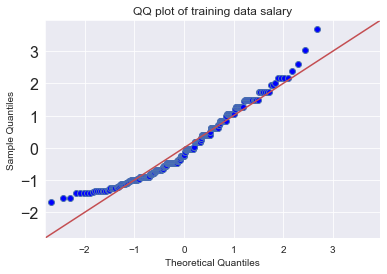

In [44]:
ax = plt.gca()
ax.set_title("QQ plot of training data salary")
sns.set(rc={'figure.figsize':(7,7)})
salary_data_train = (train_df.iloc[:,-1]-train_df.iloc[:,-1].mean())/train_df.iloc[:,-1].std()
fig = sm.graphics.qqplot(salary_data_train,dist=stats.norm, line='45', fit=True, ax=ax)
fig.show();

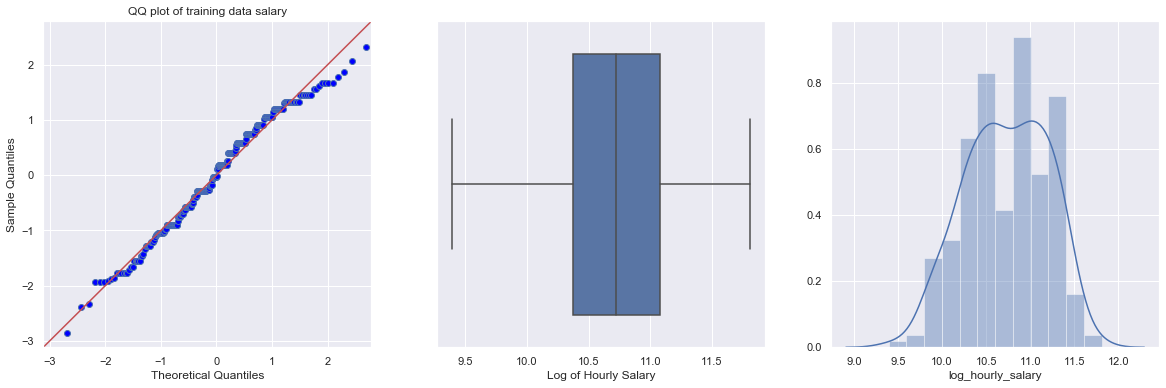

In [45]:
# train_df['log_hourly_salary'] = np.log(train_df.salary_from_page_source_conv_hourly)
train_df['log_hourly_salary'] = np.log(train_df.salary_from_page_source_as_stated)

fig, ax = plt.subplots(1,3, figsize=(20, 6))
# ax = plt.gca()
ax[0].set_title("QQ plot of training data salary")
salary_data_train = (train_df.log_hourly_salary-train_df.log_hourly_salary.mean())/train_df.log_hourly_salary.std()
sm.graphics.qqplot(salary_data_train,dist=stats.norm, line='45', fit=True, ax=ax[0])
sns.boxplot(train_df.log_hourly_salary, ax=ax[1])
ax[1].set_xlabel('Log of Hourly Salary')
ax[1].set_ylabel(' ')
sns.distplot(train_df.log_hourly_salary, ax=ax[2])
ax[1].set_xlabel('Log of Hourly Salary')
ax[1].set_ylabel(' ')
plt.show()

Now our target variable seems a lot more normal and we can look at our independent variables now!

We now have 8 different, binary variables. Before fitting a regression model, let's plot their distribution. 

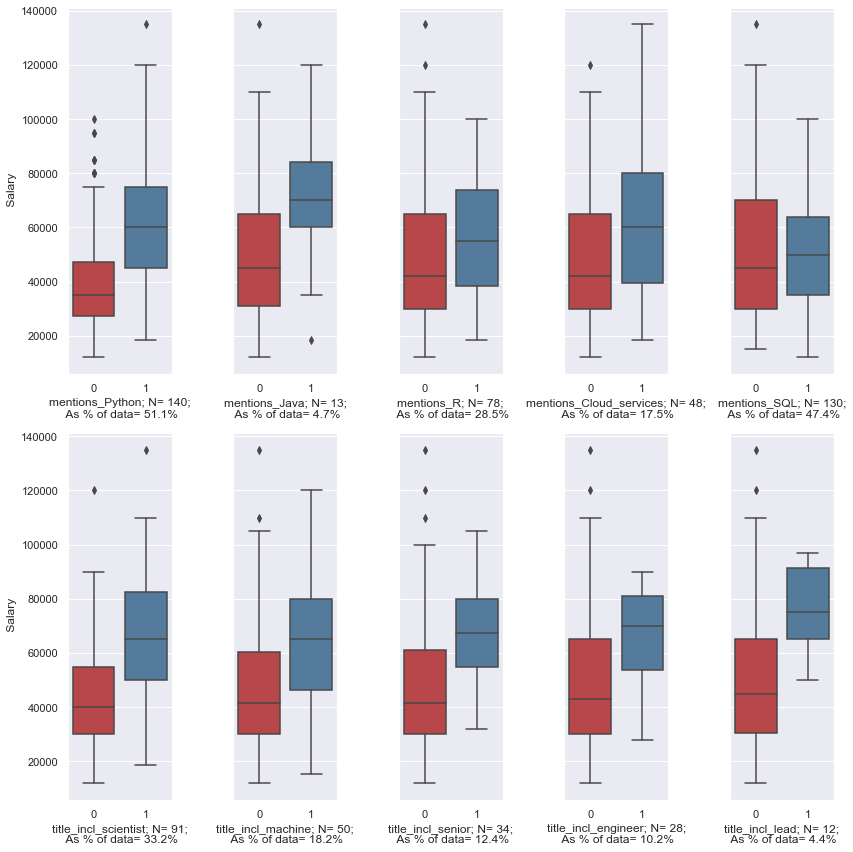

In [46]:
num_rows, num_cols = 2, 5
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,12), sharey=True)
col_id = 0

for i in range(num_rows):
    for j in range(num_cols):
        var_column  = x_train.columns[col_id]
        n_var_nonzero = np.count_nonzero(x_train[var_column])
        sample_size = len(x_train)
        y_var = train_df.salary_from_page_source_as_stated
#         y_var = train-df.salary_from_page_source_conv_hourly
        sns.boxplot(x = x_train[var_column], y = y_var, ax=ax[i, j], palette='Set1', saturation=0.55)
        if j==0:
            ax[i,j].set_ylabel(' Salary')
        else:
            ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel(f'{var_column}; N= {n_var_nonzero};\n As % of data= {round(100*n_var_nonzero/sample_size,1)}%')
        col_id+=1
        plt.tight_layout()
    

As we can see from the boxplots below, we should hope for some predictive power based on features such as the mention of Python, location in London and perhaps even the title including senior.

Let's put it all together in a model. 

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 1031 to 562
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mentions_Python                    274 non-null    int64  
 1   mentions_Java                      274 non-null    int64  
 2   mentions_R                         274 non-null    int64  
 3   mentions_Cloud_services            274 non-null    int64  
 4   mentions_SQL                       274 non-null    int64  
 5   title_incl_scientist               274 non-null    int64  
 6   title_incl_machine                 274 non-null    int64  
 7   title_incl_senior                  274 non-null    int64  
 8   title_incl_engineer                274 non-null    int64  
 9   title_incl_lead                    274 non-null    int64  
 10  salary_from_page_source_as_stated  274 non-null    float64
 11  log_hourly_salary                  274 non-null    floa

Since we're using and testing the effect of 11 different variables, we'll divide our alpha of 0.05 by 11, giving us roughly an alpha of 0.0045.

In [48]:
input_train = sm.add_constant(train_df.iloc[:, :10])
target_train = train_df.log_hourly_salary

In [49]:
model = sm.OLS(target_train, input_train)
baseline_fitted = model.fit()

baseline_fitted.summary(alpha=0.005)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_hourly_salary   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     20.75
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           3.17e-28
Time:                        09:09:08   Log-Likelihood:                -100.89
No. Observations:                 274   AIC:                             223.8
Df Residuals:                     263   BIC:                             263.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|     [0.0025     0.9975]
-------------------------------------------------------------------------------------------
const                      10.3837      0.039    265.350      0.000      10.273      10.494
mentions_Python             0.2724      0.064      4.253      0.000       0.091       0.454
mentions_Java              -0.0114      0.107     -0.106      0.915      -0.315       0.292
mentions_R                 -0.0981      0.059     -1.670      0.096      -0.264       0.068
mentions_Cloud_services     0.0371      0.062      0.601      0.549      -0.138       0.212
mentions_SQL                0.0252      0.048      0.525      0.600      -0.111       0.161
title_incl_scientist        0.3030      0.056      5.417      0.000       0.145       0.461
title_incl_machine          0.2067      0.083      2.497      0.013      -0.028       0.441
title_incl_senior           0.3446      0.068      5.073      0.000       0.152       0.537
title_incl_engineer         0.1270      0.101      1.259      0.209      -0.158       0.412
title_incl_lead             0.5205      0.109      4.782      0.000       0.212       0.829
==============================================================================
Omnibus:                        4.467   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                4.579
Skew:                          -0.195   Prob(JB):                        0.101
Kurtosis:                       3.500   Cond. No.                         7.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Given the many variables showing high p-values, we do not have sufficient evidence to say they have an effect on the price. So the variables that we have at least some evidence of saying that they have an impact, and will keep in the refined model, are:
* mentions_Python
* title_incl_senior
* title_incl_lead
* title_incl_scientist

Our residuals mostly follow the normal distribution pattern, except towards the lower end - our model is not particularly good at estimating the lower values of salary.

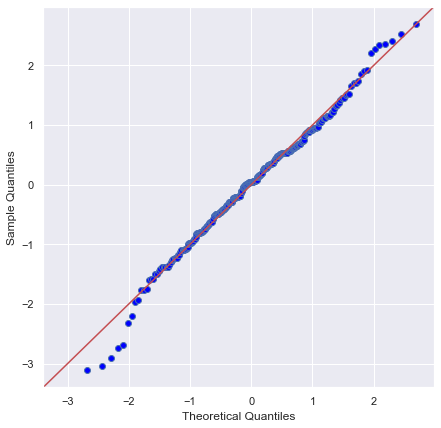

In [50]:
residuals_multivariate_model = baseline_fitted.resid
fig = sm.graphics.qqplot(residuals_multivariate_model,dist=stats.norm, line='45', fit=True)
fig.show()

In [51]:
val_input = sm.add_constant(x_val)
val_preds = baseline_fitted.predict(val_input)
valid_table = pd.DataFrame({'target_val_log_salary' : np.log(y_val),
                           'predicted_val_log_salary':val_preds,
                           'squared_error': (np.log(y_val)-val_preds)**2 })
valid_table.describe()

,target_val_log_salary,predicted_val_log_salary,squared_error
count,31.000000,31.000000,31.000000
mean,10.768924,10.758571,0.090904
std,0.432910,0.339896,0.131501
min,10.043249,10.383654,0.000317
25%,10.308953,10.396272,0.015107
50%,10.819778,10.718385,0.034043
75%,11.119197,10.981304,0.111953
max,11.608236,11.381463,0.558549


Our baseline model has a mean squared error of 0.1 on validation data (n = 31). We will now move to drop the non-significant variables from our training data, train a second model, and then validate it. 

In [52]:
train_df_redu = train_df[['mentions_Python', 'title_incl_senior', 'title_incl_lead','title_incl_scientist']]
input_train = sm.add_constant(train_df_redu)
target_train = train_df.log_hourly_salary

In [53]:
model = sm.OLS(target_train, input_train)
model_2_fitted = model.fit()

model_2_fitted.summary(alpha=0.005)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_hourly_salary   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     42.28
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           1.71e-27
Time:                        09:09:09   Log-Likelihood:                -113.77
No. Observations:                 274   AIC:                             237.5
Df Residuals:                     269   BIC:                             255.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|     [0.0025     0.9975]
----------------------------------------------------------------------------------------
const                   10.4201      0.033    312.431      0.000      10.326      10.515
mentions_Python          0.3442      0.050      6.863      0.000       0.202       0.486
title_incl_senior        0.3176      0.069      4.604      0.000       0.122       0.513
title_incl_lead          0.5338      0.111      4.817      0.000       0.220       0.847
title_incl_scientist     0.2136      0.053      4.027      0.000       0.063       0.364
==============================================================================
Omnibus:                        1.548   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                1.252
Skew:                          -0.103   Prob(JB):                        0.535
Kurtosis:                       3.259   Cond. No.                         6.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

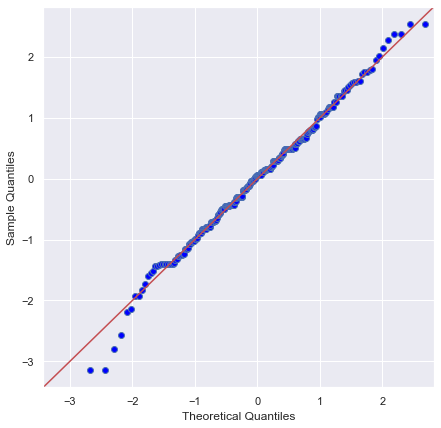

In [54]:
residuals_multivariate_model = model_2_fitted.resid
fig = sm.graphics.qqplot(residuals_multivariate_model,dist=stats.norm, line='45', fit=True)
fig.show()

In [55]:
x_val_redu = x_val[['mentions_Python', 'title_incl_senior', 'title_incl_lead', 'title_incl_scientist']]
val_input = sm.add_constant(x_val_redu)
val_preds = model_2_fitted.predict(val_input)
valid_res_model_2 = pd.DataFrame({'target_val_log_salary' : np.log(y_val),
                           'predicted_val_log_salary':val_preds,
                           'squared_error': round((np.log(y_val)-val_preds)**2 ,3)})
valid_res_model_2.describe()

,target_val_log_salary,predicted_val_log_salary,squared_error
count,31.000000,31.000000,31.000000
mean,10.768924,10.758372,0.118742
std,0.432910,0.318406,0.152299
min,10.043249,10.420131,0.000000
25%,10.308953,10.420131,0.023000
50%,10.819778,10.764317,0.043000
75%,11.119197,10.977888,0.147500
max,11.608236,11.511641,0.545000


This latest model accounts for only about 37.7% of the variance in the data (and the plot below displays this to some extent), and our mean squared error on log salary has increased to 0.12. 


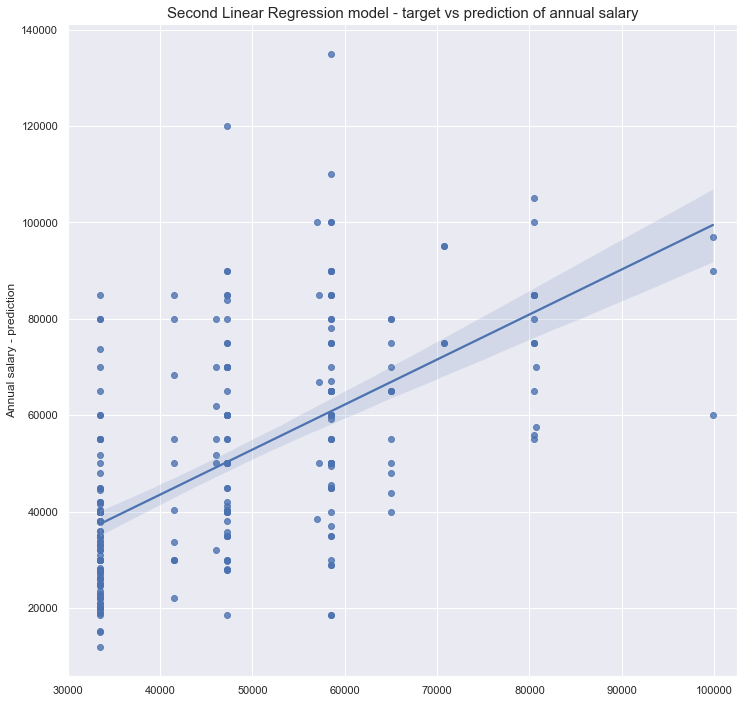

In [56]:
plt.figure(figsize=(12,12))
train_preds = np.exp(model_2_fitted.predict(input_train))
plt.title('Second Linear Regression model - target vs prediction of annual salary', fontdict={'size':15})
sns.regplot(y=np.exp(target_train),x=train_preds, )
plt.ylabel('Annual salary - target')
plt.ylabel('Annual salary - prediction')
plt.xlim(30000, 102500)
plt.show()

### Cross-validating model

In [57]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

lin_reg_skl = LinearRegression()

In [58]:
cross_val_input = sm.add_constant(x_train_val[['mentions_Python', 'title_incl_senior', 'title_incl_lead', 'title_incl_scientist']],)
cross_val_target = np.log(y_train_val)
estimators = cross_validate(lin_reg_skl , cross_val_input, cross_val_target, scoring='r2', cv=10, return_estimator=True)

In [59]:
estimators['test_score']

array([0.28377562, 0.45683503, 0.35798178, 0.46379416, 0.37690985,
       0.13575946, 0.48337337, 0.0111018 , 0.44647207, 0.34661841])

In [60]:
# selecting linear reg model with best score
best_estimator = estimators['estimator'][6]
best_estimator

LinearRegression()

In [61]:
best_estimator.coef_
# best_estimator.intercept_

array([0.        , 0.33899505, 0.31259968, 0.51867273, 0.19139909])

In [62]:
best_estimator.intercept_


10.429023203844263

### Testing cross-validated model

In [63]:
test_input = sm.add_constant(x_test[['mentions_Python', 'title_incl_senior', 'title_incl_lead', 'title_incl_scientist']],)
test_target = np.log(y_test)

test_preds = best_estimator.predict(test_input)
test_res = pd.DataFrame({'target_test_log_salary' : test_target,
                           'predicted_test_log_salary':test_preds,
                           'squared_error': (test_target-test_preds)**2})
test_res.describe()

,target_test_log_salary,predicted_test_log_salary,squared_error
count,77.000000,77.000000,77.000000
mean,10.760955,10.733748,0.100552
std,0.400442,0.325260,0.124340
min,9.952278,10.429023,0.000249
25%,10.505013,10.429023,0.015061
50%,10.714418,10.741623,0.069172
75%,11.082143,10.959417,0.142252
max,11.512925,11.478090,0.619594


In [64]:
test_res['target_test_annual_sal'] = np.exp(test_res.target_test_log_salary)
test_res['predicted_test_annual_sal'] = np.exp(test_res.predicted_test_log_salary)
test_res['squared_error_annual_salary'] = np.sqrt((test_res['target_test_annual_sal'] - test_res['predicted_test_annual_sal'])**2)
test_res.iloc[:,3:6].describe()

,target_test_annual_sal,predicted_test_annual_sal,squared_error_annual_salary
count,77.000000,77.000000,77.000000
mean,50962.792208,48539.971591,12955.561992
std,20319.266631,17888.847254,10223.514158
min,21000.000000,33827.291749,640.909518
25%,36498.000000,33827.291749,6172.708251
50%,45000.000000,46241.034962,10979.835112
75%,65000.000000,57492.934352,18591.357747
max,100000.000000,96576.436866,49037.090482


In [65]:
#interpreting outputs of the model - 'lead' coefficient
np.exp(10.429023203844263 + 0.51867273) - np.exp(10.429023203844263)

22995.67878976377

In [66]:
#interpreting outputs of the model - 'scientist' coefficient
np.exp(10.429023203844263 + 0.19139909) - np.exp(10.429023203844263)

7135.617912720598

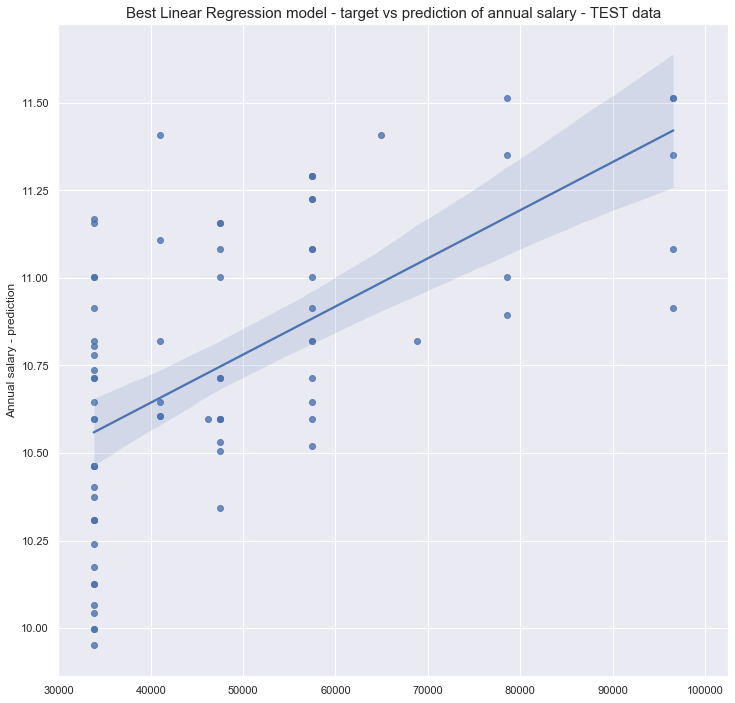

In [67]:
plt.figure(figsize=(12,12))
test_input = sm.add_constant(x_test[['mentions_Python', 'title_incl_senior', 'title_incl_lead', 'title_incl_scientist']],)
test_target = np.log(y_test)
test_preds = np.exp(best_estimator.predict(test_input))

plt.title('Best Linear Regression model - target vs prediction of annual salary - TEST data', fontdict={'size':15})
sns.regplot(y=test_target,x=test_preds, )
plt.ylabel('Annual salary - target')
plt.ylabel('Annual salary - prediction')
plt.xlim(30000, 102500)
plt.show()

<div class="alert alert-block alert-info">

## Insights and model interpretation:

* So our model has a root-mean squared error of about £13000 on test data, which is a very wide margin for our purposes. So if we took a job post and predicted that the role should be paid around £40 000, on average the answer would be that, give or take £13k. Therefore this tool needs more / different data and features before it can be useful. 
    
* For our best model, the strongest determiner of salary was the presence of the word 'lead' in the title - according to the model, the difference between a role that has lead in the title and one that doesn't is, on average, £23k. 
    
* The weakest feature was whether the title included salary - acc to the same model, the difference you'd expect in salary for a role that has the word 'scientist' in the title vs one that does not, was about £7k. 
    
* Since the model performs quite poorly, I will also attempt an ordinal logistic regression on binned salary data with the current data (binned into categories such as £20'000 - 25'000). If successful, such a model wouldn't provide predictions that are as precise, but it would at least give an indication of what *band* we expect a job's salary to be in.
    
</div>



### Predicting salary bands

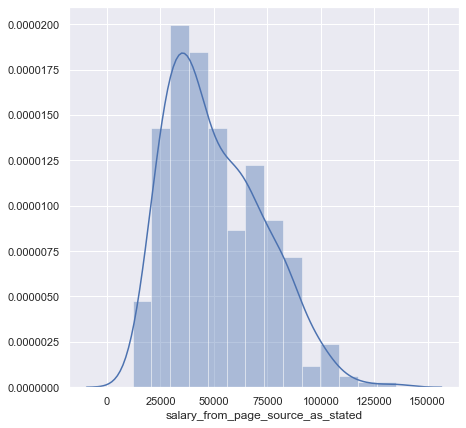

count       382.000000
mean      50888.617801
std       22309.386850
min       12000.000000
25%       33000.000000
50%       45285.500000
75%       65000.000000
max      135000.000000
Name: salary_from_page_source_as_stated, dtype: float64

In [68]:
sns.distplot(y)
plt.show()
y.describe()

In [69]:
# truncating the data to be in intervals that mostly capture the whole interquartile range, but with some extra salary bands at the bottom, from around 25k to 65k 
salary_intervals = pd.IntervalIndex.from_tuples([ (0, 25000),(25000, 30000),(30000, 35001), (35001, 40000), (40001, 45000),
                                                (45001, 50000), (50001, 55000), (55001, 60000),
                                                (60001, 65000), (65001, 150000)])


y_ord = pd.cut(y.to_list(), bins = salary_intervals, )
# y_ord_df = pd.DataFrame(y_ord, index=y.index)
# y_ord.categories = labels
y_ord = pd.Series(y_ord, name='Salary_bands', index = y.index)
y_ord

0            (0, 25000]
4        (60001, 65000]
8        (30000, 35001]
10       (35001, 40000]
12           (0, 25000]
             ...       
1071    (65001, 150000]
1074     (50001, 55000]
1075    (65001, 150000]
1080     (60001, 65000]
1081     (50001, 55000]
Name: Salary_bands, Length: 382, dtype: category
Categories (10, interval[int64]): [(0, 25000] < (25000, 30000] < (30000, 35001] < (35001, 40000] ... (50001, 55000] < (55001, 60000] < (60001, 65000] < (65001, 150000]]

In [70]:
# Create a numerical rank variable that corresponds to our salary bands-> this is so that the regression algorithm can 
# interpret the order of the salary bands, which matters for our purposes
y_ord_rank = pd.Series(y_ord.rank(method='dense'), index=y.index, name='Salary_rank', dtype='int')

y_ord_full = pd.concat([y_ord, y_ord_rank], axis=1)

In [71]:
y_ord_full.head()

,Salary_bands,Salary_rank
0,"(0, 25000]",1
4,"(60001, 65000]",9
8,"(30000, 35001]",3
10,"(35001, 40000]",4
12,"(0, 25000]",1


In [72]:
test_y_qual  = pd.concat([y_ord_full, y ], axis=1)
test_y_qual.tail()

,Salary_bands,Salary_rank,salary_from_page_source_as_stated
1071,"(65001, 150000]",10,66823.0
1074,"(50001, 55000]",7,55000.0
1075,"(65001, 150000]",10,70000.0
1080,"(60001, 65000]",9,65000.0
1081,"(50001, 55000]",7,55000.0


In [73]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 0 to 1081
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   mentions_Python          382 non-null    int64
 1   mentions_Java            382 non-null    int64
 2   mentions_R               382 non-null    int64
 3   mentions_Cloud_services  382 non-null    int64
 4   mentions_SQL             382 non-null    int64
 5   title_incl_scientist     382 non-null    int64
 6   title_incl_machine       382 non-null    int64
 7   title_incl_senior        382 non-null    int64
 8   title_incl_engineer      382 non-null    int64
 9   title_incl_lead          382 non-null    int64
dtypes: int64(10)
memory usage: 42.8 KB


In [74]:
# x, y = final_analytic_df.iloc[:, 1:], final_analytic_df['salary_from_page_source_conv_hourly']

features = ['mentions_Python', 'title_incl_senior', 'title_incl_lead', 'title_incl_scientist']

x_train_val, x_test,y_train_val_ord, y_test_ord = train_test_split(x[features], y_ord_full, test_size=.25, random_state=12345,)
# x_train, x_val, y_train_ord, y_val_ord = train_test_split(x_train_val, y_train_val_ord, test_size=.1, random_state=12345,)


train_val_df_ord = x_train_val.join(y_train_val_ord)
test_df_ord = x_test.join(y_test_ord)

train_val_df_ord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 179 to 777
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   mentions_Python       286 non-null    int64   
 1   title_incl_senior     286 non-null    int64   
 2   title_incl_lead       286 non-null    int64   
 3   title_incl_scientist  286 non-null    int64   
 4   Salary_bands          286 non-null    category
 5   Salary_rank           286 non-null    int64   
dtypes: category(1), int64(5)
memory usage: 24.2 KB


The package used in python for ordinal regression here is [`mord`](https://pythonhosted.org/mord/) and the inspiration for use and implementation was taken from [this article](https://rikunert.com/ordinal_rating).

### Oversampling due to unbalanced target data:

In [75]:
from imblearn.over_sampling import RandomOverSampler

In [91]:
ros = RandomOverSampler(random_state=12345, )
x_train_val_res, y_train_val_ord_res = ros.fit_sample(x_train_val, y_train_val_ord.Salary_rank)

In [92]:
y_train_val_ord_res.value_counts()

10    72
9     72
8     72
7     72
6     72
5     72
4     72
3     72
2     72
1     72
Name: Salary_rank, dtype: int64

In [93]:
x_train_val_res = x_train_val_res.dropna()
x_train_val_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   mentions_Python       720 non-null    int64
 1   title_incl_senior     720 non-null    int64
 2   title_incl_lead       720 non-null    int64
 3   title_incl_scientist  720 non-null    int64
dtypes: int64(4)
memory usage: 28.1 KB


In [96]:
from mord import LogisticAT
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, make_scorer, f1_score
from sklearn.model_selection import cross_val_score
#ordinal regression package for python; data is not scaled so no regularizing
ord_model = LogisticAT(alpha=0)
logit = LogisticRegression()
# making an sklearn scorer based on absolute error
MAE = make_scorer(mean_absolute_error)

estimator_cv_acc = cross_val_score(ord_model, X=x_train_val_res, y=y_train_val_ord_res, scoring='accuracy', cv=10)
print("The mean accuracy for our Ordinal Regression model was ", np.mean(estimator_cv_acc))

estimator_cv_mae = cross_val_score(ord_model, X=x_train_val_res, y=y_train_val_ord_res, scoring=MAE, cv=10)
print("The mean absolute error for our Ordinal Regression model was ", np.mean(estimator_cv_mae))

The mean accuracy for our Ordinal Regression model was  0.09166666666666667
The mean absolute error for our Ordinal Regression model was  2.1819444444444445


In [101]:
estimator_cv = cross_validate(ord_model, x_train_val_res, y_train_val_ord_res, scoring='balanced_accuracy', cv=10, return_estimator=True)

In [102]:
# getting index for the model with the best performance on validation data
best_model_index = np.argmax(estimator_cv['test_score'])
best_ord_model = estimator_cv['estimator'][best_model_index]

best_ord_model

LogisticAT(alpha=0)

In [103]:
best_ord_model.coef_

array([1.33309331, 1.9707252 , 4.10654077, 0.90069345])

In [104]:
ord_model_results = pd.DataFrame({'Test_salary_rank_inputs': y_test_ord.Salary_rank ,
                                  'Test_salary_rank_preds' : best_ord_model.predict(x_test),
                                  'Test_salary_bands': y_test_ord.Salary_bands}, index=y_test_ord.index,).sort_values('Test_salary_rank_inputs')

ord_model_results.head(10)

,Test_salary_rank_inputs,Test_salary_rank_preds,Test_salary_bands
285,1,4,"(0, 25000]"
12,1,4,"(0, 25000]"
250,1,4,"(0, 25000]"
277,1,4,"(0, 25000]"
227,1,4,"(0, 25000]"
192,1,4,"(0, 25000]"
482,1,4,"(0, 25000]"
394,1,4,"(0, 25000]"
107,1,4,"(0, 25000]"
291,1,4,"(0, 25000]"


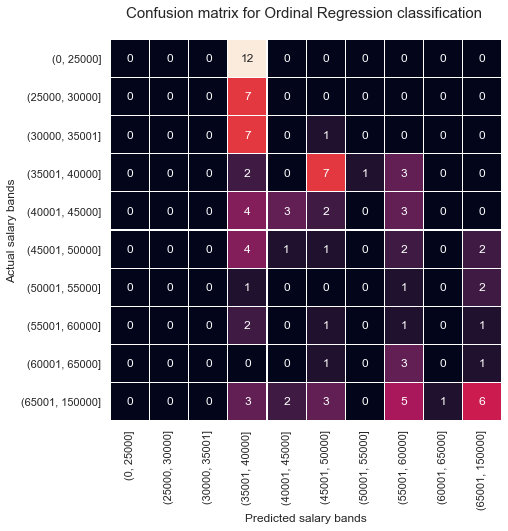

In [105]:
from sklearn.metrics import confusion_matrix

sns.heatmap( confusion_matrix(ord_model_results.Test_salary_rank_inputs, 
                              ord_model_results.Test_salary_rank_preds), 
            annot=True, cbar=False, linewidths=0.05,yticklabels = ord_model_results.Test_salary_bands.unique(), xticklabels = ord_model_results.Test_salary_bands.unique())
plt.title('Confusion matrix for Ordinal Regression classification \n', fontdict={'size': 15})
plt.xlabel("Predicted salary bands")
plt.ylabel("Actual salary bands")
plt.show()

### Interpreting model

Sadly the model failed to perform to any reasonable standard. The confusion matrix above shows that, based on what data we have, we are extremely unlikely to be able to predict even salary band with any great confidence. The only exceptions seemed to be the 30 to 35k band and the 65k and above band. 

Given these results, my conclusion for the moment is that there simply isn't enough data at the moment to build a reliable classification and prediction tool. 

## 6. Is there a relationship between years of experience required and the salary? 

Many new data scientists find it vexing or dissapointing when they search for an "entry-level" position and find that it requires 3 years of experience in the field. But do the years of experience stated in the job ad actually have anything to do with something more concrete, like pay? 

Given the data, I am going to build a simple regex function for extracting ranges of years that jobs are seeking. This will be computed for the full set of data, and then compared for the subset that contains salary data as well. I will run a correlation test, with an alpha of 0.05. I'm expecting there to be relatively little data, based on the initial cleaning rounds I completed in the cleaning notebook, so my expectations are:

a. The data will be unsuited for pearson's parametric test since it won't meet assumptions, so I will use the non-parametric [Spearman Ranked correlation test](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)

b. The data will be scarce so I'm expecting a high p-value and thus a result that is likely to not be significant. 

My regex will be effective looking for a pattern like "(number + hyphen / to) + number + year(s) + (of) + experience". My regex pattern is shown in the cell below, the function is stored in functions.py. The first column produced, `experience_regex` is the raw output, which will be the starting point for producing our higher quality feature column, `experience`. 

The initial search is fairly greedy (captures a lot of different cases - casts a wide net, if you will) and we can selectively trim down the ones that clearly aren't useful. I've limited the number retrieving to only getting single digit numbers - if a company is looking for 10 years of experience,that's quite an outlier and I'd suspect that it's more like the job descriptions mentions the company having 10 years of experience in doing X, rather than demanding that from a potential employee.

In [177]:
exp_pattern = """[0-9]?[ ]?\-?[ ]?(?<![0-9])\d(?=\s)[ ]?[a-z]* year[s]? expe[a-z]*|
                |[0-9]?[ ]?to[ ]?(?<![0-9])\d(?=\s)[ ]?[a-z]* year[s]? expe[a-z]*|
                |[0-9]?[ ]?\-?[ ]?(?<![0-9])\d(?=\s)[ ]?[a-z]* year[s]? of expe[a-z]*|
                |[0-9]?[ ]?to[ ]?(?<![0-9])\d(?=\s)[ ]?[a-z]* year[s]? of expe[a-z]*|
                |[0-9]?[ ]?\-?[ ]?(?<![0-9])\d(?=\s)[ ]?[a-z]* year[s]? work[ing]? expe[a-z]*|
                |[0-9]?[ ]?to[ ]?(?<![0-9])\d(?=\s)[ ]?[a-z]* year[s]? work[ing]? expe[a-z]*|
                |[a-z]+ year[s]? expe[a-z]*"""

In [178]:
df['experience_regex'] = df.job_descr.apply(lambda x: fn.get_experience(exp_pattern, x))

In [179]:
pd.set_option('display.max_rows', 100)
(df.experience_regex.value_counts())

 2 year experience           19
 3 year experience           17
 2 year of experience        11
 3 year of experience        10
 5 year of experience         9
 1 year experience            5
 5 year experience            5
 4 year experience            4
two year experience           4
 4 year of experience         4
1-2 year experience           3
of year experience            3
2-3 year experience           2
4-8 year work experience      2
several year experience       2
2-3 years experience          2
one year experience           2
3-5 year experience           2
next year experience          1
5 to 6 year experienced       1
5-7 year experience           1
2 4 year experience           1
2 4 year of experience        1
3-5 year of experience        1
4 8 year of experiencejob     1
3 year experience             1
 6 year of experience         1
 to 5 year experience         1
 1 year of experience         1
2-5 year of experience        1
 3 year work experience       1
1-3 year

In [180]:
# given the above case, let's also check the 'to 5 year experience case'
# as suspected, the role asks for up to 5 years
df.loc[df.experience_regex ==' to 5 year experience']['job_descr'][695]

'About the Role You will be working with the leading Location Intelligence team across the world responsible for delivering advanced spatial analysis and insight to major organisation across a range of sector We software and the latest data to help our client optimise their location strategy across both the physical and digital landscape Projects typically last between a week and 6 month ranging from performance analysis customer insight defining network strategy BI visualisation and advanced modelling We work closely with our client to ensure we understand their aim and objective their and and develop a bespoke solution to meet their business About CACI At CACI we believe every organisation should do amazing thing with data to evidence decision and identify opportunity We provide our client with actionable solution problem and pride ourselves in having market-leading capability in all key area of service doing the right thing for our client to ensure long-lasting relationship Skills a

In [191]:
# create new column for cleaned exp
df['experience_in_years'] = np.NaN
# assign the clean values for the straightforward cases
df.loc[((df.experience_regex == " 3 year experience" )| (df.experience_regex == "3 year experience")), 'experience_in_years'] = 3 
df.loc[((df.experience_regex == " 2 year experience" )| (df.experience_regex == "2 year experience")), 'experience_in_years'] = 2 
df.loc[((df.experience_regex == " 1 year experience" )| (df.experience_regex == "1 year experience")), 'experience_in_years'] = 1 
df.loc[((df.experience_regex == " 4 year experience" )| (df.experience_regex == "4 year experience")), 'experience_in_years'] = 4 
df.loc[((df.experience_regex == " 5 year experience" )| (df.experience_regex == "5 year experience")), 'experience_in_years'] = 5 
# assign clean values for numbers expressed as words
df.loc[(df.experience_regex == " two year experience"), 'experience_in_years'] = 2
df.loc[(df.experience_regex == " three year experience"), 'experience_in_years'] = 3
df.loc[(df.experience_regex == " one year experience"), 'experience_in_years'] = 1
df.loc[(df.experience_regex == " several year experience"), 'experience_in_years'] = 4
# assign midway values to the ranges
df.loc[((df.experience_regex == " 1-2 year experience") | (df.experience_regex == "1 to 2 year experience")), 'experience_in_years'] = 1.5
df.loc[((df.experience_regex == " 2-3 year experience") | (df.experience_regex == "2 to 3 year experience")), 'experience_in_years'] = 2.5
df.loc[((df.experience_regex == " 3-4 year experience") | (df.experience_regex == "3 to 4 year experience")), 'experience_in_years'] = 3.5
df.loc[((df.experience_regex == " 4-5 year experience") | (df.experience_regex == "4 to 5 year experience")), 'experience_in_years'] = 4.5
df.loc[((df.experience_regex == " 5-6 year experience") | (df.experience_regex == "5 to 6 year experience")), 'experience_in_years'] = 5.5
df.loc[((df.experience_regex == " 3-5 year experience") | (df.experience_regex == "3 to 5 year experience")), 'experience_in_years'] = 4
df.loc[((df.experience_regex == " 4-5 year experience") | (df.experience_regex == "4 to 5 year experience") | (df.experience_regex == "4 to 5 year work experience")), 'experience_in_years'] = 4.5
df.loc[((df.experience_regex == " 5-7 year experience") | (df.experience_regex == "5 to 7 year experience")), 'experience_in_years'] = 6
df.loc[((df.experience_regex == " 4 8 year of experiencejob") | (df.experience_regex == "4-8 year work experience")), 'experience_in_years'] = 6

df.loc[((df.experience_regex == "1-3 year of experience") | (df.experience_regex == "1-3 year work experience") | (df.experience_regex == "1-3 year experience")), 'experience_in_years'] = 2
df.loc[((df.experience_regex == "1-2 year of experience") | (df.experience_regex == "1-2 year work experience")), 'experience_in_years'] = 1.5
df.loc[(df.experience_regex == "3-7 year of experience"), 'experience_in_years'] = 5
df.loc[(df.experience_regex == "2-4 year of experience"), 'experience_in_years'] = 3
df.loc[(df.experience_regex == " 6 year of experience"), 'experience_in_years'] = 3

df.loc[(df.experience_regex == " 2 4 year experience"), 'experience_in_years'] = 3
#assign values to the edge cases we detected above
df.loc[(df.experience_regex == " 5 year experience"), 'experience_in_years'] = 2.5
df.loc[(df.experience_regex == "10 year experience"), 'experience_in_years'] = 7.5

df.experience_in_years.value_counts()

2.0    22
3.0    20
2.5     5
1.0     5
4.0     4
6.0     2
1.5     2
5.0     1
Name: experience_in_years, dtype: int64

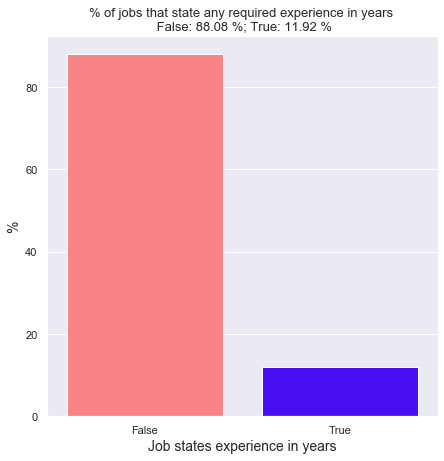

In [192]:
# according to our regex wrangling and cleaning, how many jobs actually state years of experience required
plt.figure(figsize=(7,7))
df['states_experience'] = ~df.experience_regex.isna()
g=df.groupby('states_experience').size().reset_index()
g.iloc[:,1] = round(g.iloc[:, 1]/len(df) * 100, 2)
plt.title(f'% of jobs that state any required experience in years \n False: {g.iloc[0,1]} %; True: {g.iloc[1,1]} %' , 
          fontdict={'size':13})
sns.barplot(data=g, x='states_experience', y=g.iloc[:,1],  palette='gnuplot2_r', saturation=0.9)
plt.xlabel('Job states experience in years', fontdict={'size':14})
plt.ylabel('%', fontdict={'size':14,},)
plt.savefig('fig/percent_jobs_state_exp.jpg')
plt.show()

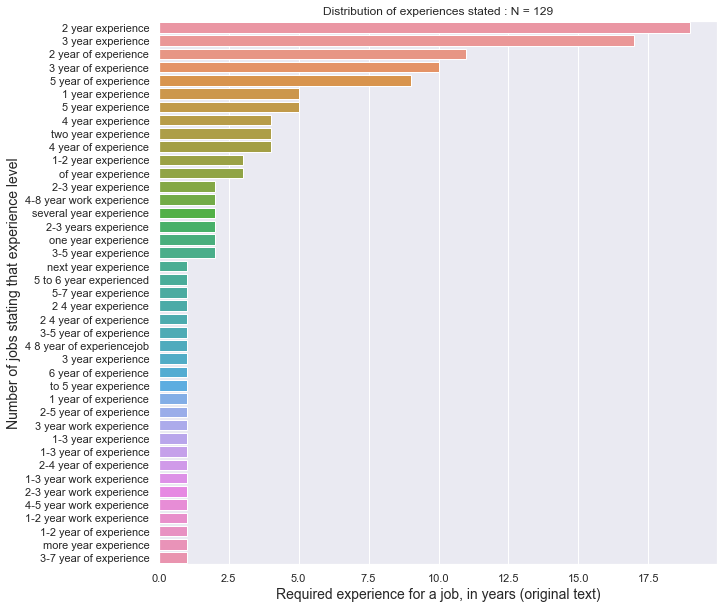

In [193]:
plt.figure(figsize=(10,10))
plt.title(f'Distribution of experiences stated : N = {len(df.loc[~df.experience_regex.isna()])}')
data_to_plot = df.loc[~df.states_experience.isna()]['experience_regex'].value_counts().astype(int)
sns.barplot(y=data_to_plot.index, x=data_to_plot.astype(int), orient='h')
plt.xlabel('Required experience for a job, in years (original text)', fontdict={'size':14})
plt.ylabel('Number of jobs stating that experience level', fontdict={'size':14,},)
plt.savefig('fig/experience_expected_raw.jpg')
plt.show()

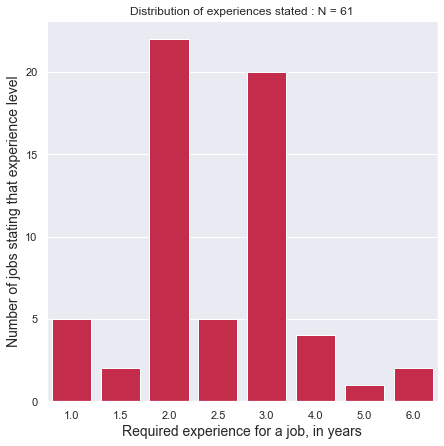

In [194]:
plt.figure(figsize=(7,7))
plt.title(f'Distribution of experiences stated : N = {len(df.loc[~df.experience_in_years.isna()])}')
data_to_plot = df.loc[~df.states_experience.isna()]['experience_in_years'].value_counts().astype(int)
sns.barplot(x=data_to_plot.index, y=data_to_plot.astype(int), color='crimson')
plt.xlabel('Required experience for a job, in years', fontdict={'size':14})
plt.ylabel('Number of jobs stating that experience level', fontdict={'size':14,},)
plt.savefig('fig/experience_expected.jpg')
plt.show()

It would seem that we haven't managed to capture that many jobs stating experience (less than 5% of the sample). The only thing left to do is to determine if there is a correlation with salary - now we have ordinal values in experience and continuous values for salary, so we will have to *rank* our variables first and then compare them using [Spearman coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). 

We have very few datapoints to use so I am expecting a high p-value, well over 0.05. 

In [195]:
sal_exp_df = df.loc[(~df.experience_in_years.isna()) & (df.salary_from_page_source_time_period=='Y')][['experience_in_years', 'salary_from_page_source_conv_hourly']]
sal_exp_df = sal_exp_df.loc[~sal_exp_df.salary_from_page_source_conv_hourly.isna()]
sal_exp_df['exp_ranked'] = sal_exp_df.experience_in_years.rank()
sal_exp_df['sal_ranked'] = sal_exp_df.salary_from_page_source_conv_hourly.rank()
sal_exp_df

,experience_in_years,salary_from_page_source_conv_hourly,exp_ranked,sal_ranked
78,2.0,12.12,7.0,1.0
150,3.0,25.29,16.0,7.0
202,2.0,14.75,7.0,3.0
226,2.0,14.49,7.0,2.0
273,2.0,23.71,7.0,5.5
315,1.0,23.71,1.0,5.5
420,2.0,18.44,7.0,4.0
521,2.0,42.15,7.0,16.0
554,2.0,26.34,7.0,8.5
571,3.0,26.34,16.0,8.5


Rather unsurprisingly, we have a non-significant result, with a p-value above 0.05.

In [196]:
stats.spearmanr(sal_exp_df['exp_ranked'], sal_exp_df['sal_ranked'])

SpearmanrResult(correlation=0.42715506990376867, pvalue=0.06814055731405226)

<div class="alert alert-block alert-warning">
       
At the 0.95 confidence level, we cannot say that there is a correlation between the salary and the experience in years expected of a role, since we cannot reject the null hypothesis. 
    
However, we must bear in mind that this is still an exploratory analysis, and that it's very possible that our test lacked the sufficient power to detect an effect. This is a test I'd like to re-run in future iterations of the project. 
    
### Future steps
   
Collect more salary and experience data in future iterations of the project and re-run the same test to confirm / falsify previous result. 
    
    
</div>

 ## 7. What are the main topics emerging from the job descriptions?
 
Frequency distribution of words across these job descriptions is not the sharpest method we could use. Although it's interesting what comes out and see how it corresponds to insights from titles. Here's a few things to note:
* Simple corpus statistics such as Frequency Distributions can either be used for generating other avenues of investigation and/or corroborating other findings
* On the latter half of the point above, if you look at our distribution plots below, you'll notice a few salient pieces of evidence:


In [203]:
%%capture
from nltk.tokenize import RegexpTokenizer
# using a lemmatizer to hopefully reduce the nr of unique but redundant words (e.g. condensing 'developer' and 'development' into 1 word)
lemmy = fn.LemmaTokenizer(tokenizer=RegexpTokenizer(pattern='\\b[A-Za-z]{3,}\\b'))
#How many terms to include
N=20

# putting software and developer into the list of stopwords - words we wish to ignore
special_sw = title_sw #adding the last two as they have come up as frequent typos
#adding a few more stopwords - these appear to be html syntax, which is very odd, since the parser should have dealt with them
for w in ['span', 'style','font', 'arial', 'serif', 'family','science', 
          'analyst', 'analysis', 'machine','experience','role', 'team', 
         'business', 'skill', 'full', 'time', 'equal', 'opportunity', 
         'work', 'new', 'service','using', 'within', 'strong', 'phone']:
    special_sw.append(w)
descr = df.job_descr.dropna()
descr_term_df = fn.get_top_n_terms(descr, N, stop_words_list=special_sw, tokenizer_obj=lemmy)
descr_bigram_df = fn.get_top_n_terms(descr, N, stop_words_list=special_sw , ngram_number=2, tokenizer_obj=lemmy)
descr_trigram_df = fn.get_top_n_terms(descr, N, stop_words_list=special_sw , ngram_number=3, tokenizer_obj=lemmy)

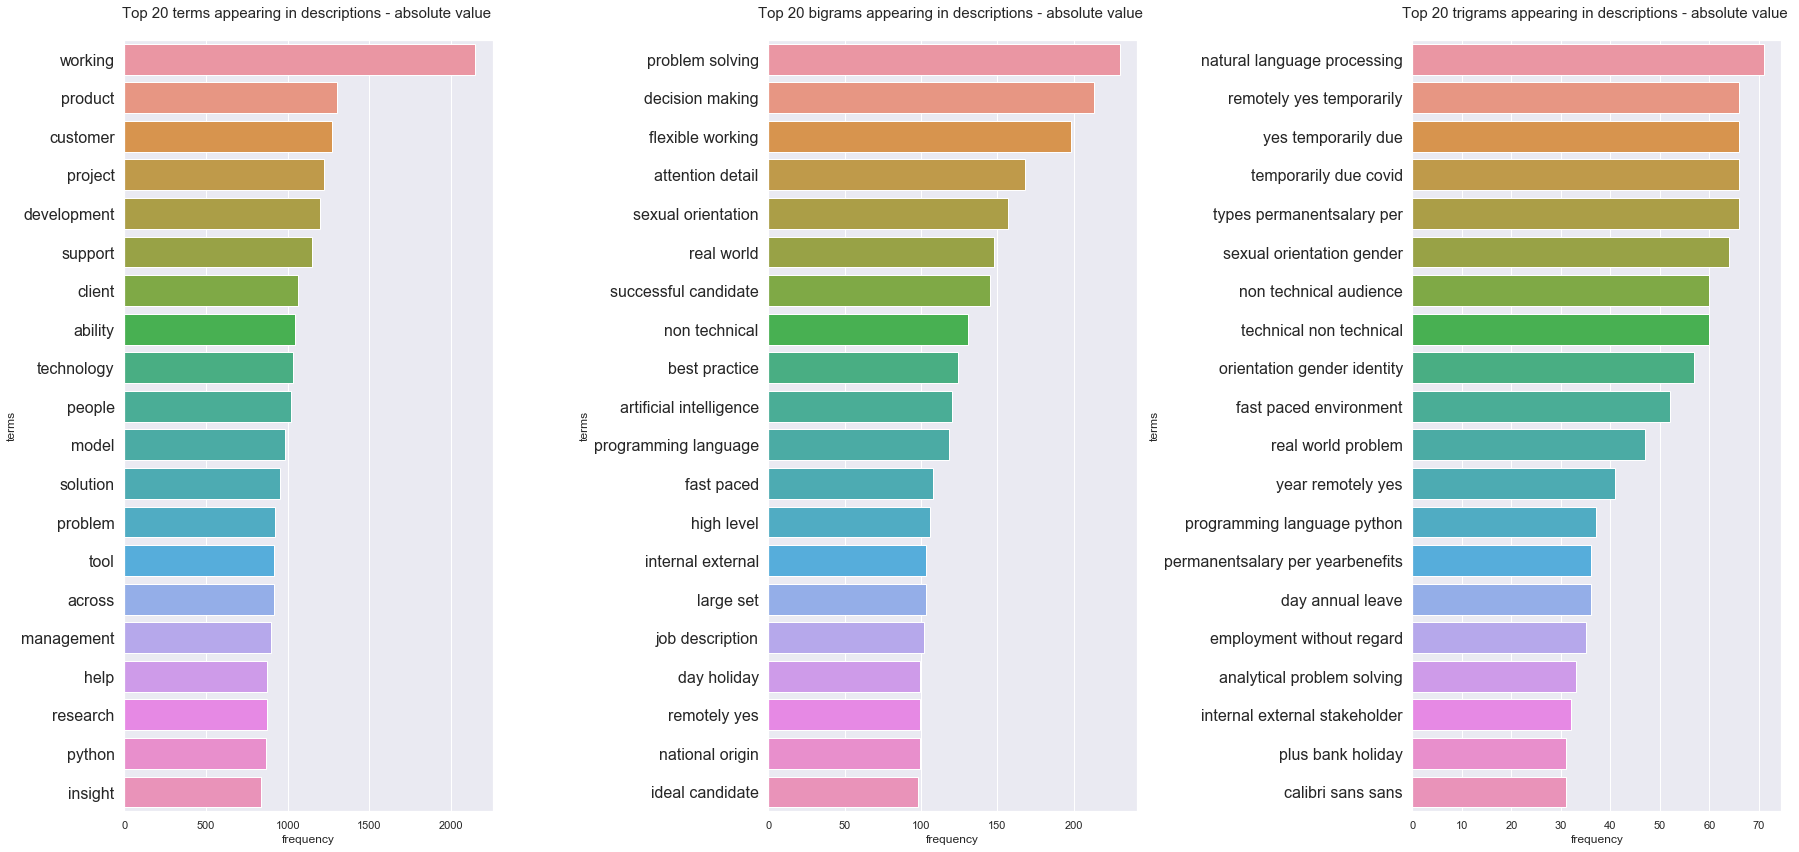

In [204]:
# plt.figure(figsize=(20,20))
fig, ax = plt.subplots(1,3, figsize=(25,12),  )

ax[0].set_title('Top {} terms appearing in descriptions - absolute value \n'.format(N), fontdict={'size':15})
ax[1].set_title('Top {} bigrams appearing in descriptions - absolute value \n'.format(N), fontdict={'size':15})
ax[2].set_title('Top {} trigrams appearing in descriptions - absolute value \n'.format(N), fontdict={'size':15})

plt.rcParams['ytick.labelsize'] = 16
sns.barplot(data= descr_term_df, x='frequency', y='terms', ax=ax[0])
sns.barplot(data= descr_bigram_df, x='frequency', y='terms', ax=ax[1])
sns.barplot(data= descr_trigram_df, x='frequency', y='terms', ax=ax[2]);

plt.tight_layout()

* As we would expect, there are a lot of terms that are simply the usual business jargon/terms (such as team, skill, product, customer); I have re-run the plots with those as stopwords - there are still some business jargon terms coming up of course
* There's a surprisingly large number of mentions for model (given lemmatization, this will include '[the] modelling', 'models' and other noun derivations)- almost 1000 mentions. This is surprising when we remember that more than a third of the roles are DA roles, which typically don't require as much experience of modelling
* there are at least 70 mentions of NLP, which is quite low and further reflects what we found earlier about the scarcity of NLP-specific jobs
* at least 60 mentions of working remote 'temporarily due to covid' - I'd argue this is probably 60 jobs in total mentioning it, since roles have no reason to duplicate the mention. 
* Whilst some might expect more mentions of AI, the frequency across the corpus of 'artificial intelligence' is around 110 - even if this was 110 separate jobs (and that's a bit of a stretch), that's barely 10% of the dataset mentioning AI. 
* there's a slight theme of "problem-solving" that comes out through some terms (though this is likely more influenced by my own knowledge of the field): terms like 'solution' and 'problem' are appearing around 900 times; 'analytical problem solving' has also appeareed at least 35 times; "problem-solving" is the most popular bigram. Whilst we cannot infer direct ways to skill bootcamp graduates using these frequency distributions, we can at least, give some indication of what terms they should include in CVs / resumes and cover letters, how they define themselves in their LinkedIn summaries. 

The next step is to look at modelling the data using unsupervised learning techniques, specifically Latent Dirichlet Allocation (LDA). 

We will start off by assuming that there are 10 topics, then investigating the model outputs via pyLDAviz, which allows us to see which terms are most relevant to a particular topic. 


In [205]:
%%time

number_topics = 10


count_vect_lem = CountVectorizer(tokenizer=fn.LemmaTokenizer(tokenizer=RegexpTokenizer(pattern='\\b[A-Za-z]{2,}\\b')),
                       strip_accents = 'unicode',
                       stop_words = special_sw,
                       lowercase = True,)

lda = LDA(n_components=number_topics,
          doc_topic_prior = 3,
          topic_word_prior = 0.05,
          n_jobs=-1, random_state=12345)



lda_data, lda_obj = topic.data_to_lda(df, 'job_descr', count_vect_lem, lda, )

CPU times: user 4.79 s, sys: 1.53 s, total: 6.32 s
Wall time: 11 s


**If you're interacting with the pyLDAvis plot below, I recommend setting the lambda slider between 0.4 and 0.6, as the optimal value for getting insights into the metric.**

In [206]:
%%time
pyLDAvis.enable_notebook()

display_data = pyLDAvis.sklearn.prepare(lda_obj, 
                         count_vect_lem.fit_transform(df['job_descr']),
                        count_vect_lem,)
pyLDAvis.display(display_data)

CPU times: user 9.49 s, sys: 232 ms, total: 9.72 s
Wall time: 11.8 s


In [207]:
pyLDAvis.save_html(display_data, 'LDA_viz_plot.html')

<div class="alert alert-block alert-info">

<h2>What are the emergent topics then? Can we assing them some kind of names based on most relevant terms that come up for them? </h2>
With unsupervised learning such as this, we must err on the side of caution and remember that a lot of noise is surfacing amongst the seemingly useful data. With that in mind:
    
    
* Topic 3 - *Product and development* - the largest topic by far (in terms of number of tokens it encompasses), is focussed on development programming languages ('java'), specific packages used for intensive machine learning ('tensorflow', 'pytorch'), niche areas ('NLP', 'neural') and mentions 'development', 'processing', 'product' and other such terms. 
* Topic 1 - *Customer-centric* - focused more on delivering insights towards customers and using tools such as dashboards, excel, [power] 'bi' and thus providing analytical insigths for the stakeholders. 
* Topic 4 - *Marketing* - 'brand', 'strategy'  etc. A less dominating topic that speaks about the interaction of the company/role with the organisation's customers and how the public per eives the 'brand'.
* Topic 6 - *Academic & Scientific comps* - this is not as significant or tightly knit a group, but the extremely high conditional probability of the topic given terms such as 'university' and 'research' points us in that direction. Note that the only other topic with a high conditional probability given the terms 'AI', 'novel', 'publication' and 'academic' is Topic 1 - Product and development.

The other topics are somewhat hard to gauge / interpret. Given what we've seen above, the final recommendations are as follows:    
    
* It's true that the topics reflect the underlying some categorisation of the data (DA vs DS vs ML) that we already had <b>BUT</b> the topic modelling has allowed for greater nuance to be captured. For instance there are roles with Data Scientist in the title that broadly reflect more of the skills you'd see in Analyst positions or in the ML end of the spectrum. The delineation between DA, DS and ML roles is not quite clear cut. 
    
</div>

<div class="alert alert-block alert-success">

## Recommendation:
    
* Moving forward with building our 'career profiles' and pathways, we can start building on the idea of directions and skills student would like to further branch into: if you want to end up in the AI-heavy side, focus on NLP, Java, tensorflow and pytorch; if they want to be more focused on a business and delivering value to stakeholders, they should concentrate on SQL, dashboarding and their communication skills. 
* At the same time, we can prepare some of the candidates for the potential obstacles that come their way - e.g. with the Product and Development end, they're more likely to be asked if they have a PhD; at the other end, in the business and Customer centric roles, they are far more likely to require use of Microsoft Excel so a quick brush up on those skills might be required.
* Can we use the topic data in future analysis? Is there any particular topic that correlates strongly with salary expectations? 


</div>

In [258]:
lda_data_corr = lda_data.loc[lda_data.salary_from_page_source_time_period=='Y'][['salary_from_page_source_as_stated', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
                         'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']].rename({'salary_from_page_source_as_stated':'annual_salary',
                                                                                         'topic_1':'Customer_centric', 'topic_3':'Product_and_dev',
                                                                                         'topic_4':'Marketing', 'topic_6':'Academic_&_research'}, axis=1).corr()
lda_data_corr['annual_salary'].sort_values(ascending=False)

annual_salary          1.000000
Academic_&_research    0.370952
topic_10               0.171272
topic_8                0.136861
topic_2                0.126595
Customer_centric       0.059533
topic_5               -0.028629
Marketing             -0.117843
Product_and_dev       -0.120457
topic_9               -0.128479
topic_7               -0.325493
Name: annual_salary, dtype: float64

Let's check to see if there is any association between the academic and research topic and salary. We'll measure this using Pearson's correlation coefficient, Pearson's r. As before, we'll use an alpha of 0.005. 
Our data meets a lot of the assumptions, but it must also be free of outliers. Hence why I cap the salary data at the 99th percentile, thus removing the extremely high salaries. 

When we look at the topic_6 scores, which are effectively, probabilities of a given document belonging to a topic, we see a very positively skewed distribution. This makes sense, most documents have a very low probability of belonging to one topic out of the 10. Given the huge number of outliers, I'll log transform the probabilities to give us the log probability of a given document belonging to a topic. 

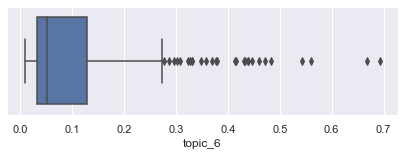

In [300]:
annual_salaries_data = lda_data.loc[((lda_data.salary_from_page_source_time_period=='Y') & 
                                     (lda_data.salary_from_page_source_as_stated<lda_data.salary_from_page_source_as_stated.quantile(0.99)))][['salary_from_page_source_as_stated', 
                                                                                                                                                   'topic_6', 'job_search_term']]
plt.figure(figsize=(7, 2))
sns.boxplot(annual_salaries_data.topic_6)
plt.show()

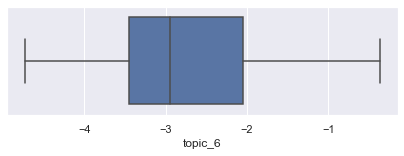

In [301]:
plt.figure(figsize=(7, 2))
annual_salaries_data['log_topic_6'] = np.log(annual_salaries_data.topic_6)
sns.boxplot(np.log(annual_salaries_data.topic_6))
plt.show()

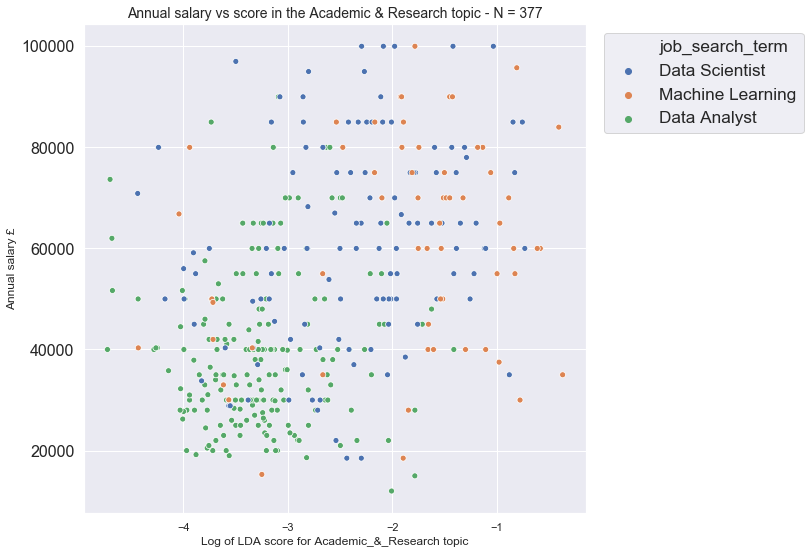

In [310]:
plt.figure(figsize=(9,9))
plt.title(f'Annual salary vs score in the Academic & Research topic - N = {len(annual_salaries_data)}', fontdict={'size':14})
sns.scatterplot(data=annual_salaries_data, x='log_topic_6', y='salary_from_page_source_as_stated', hue='job_search_term', hue_order=['Data Scientist', 'Machine Learning', 'Data Analyst'])
plt.xlabel('Log of LDA score for Academic_&_Research topic')
plt.ylabel('Annual salary £')
plt.legend(fontsize='x-large', loc='upper right', bbox_to_anchor=(1.45, 1))
plt.show()

In [306]:
anual_salaries = annual_salaries_data.salary_from_page_source_as_stated
academia_topic = annual_salaries_data.log_topic_6

stats.pearsonr(anual_salaries, academia_topic)

(0.4236228283527784, 7.52679120042345e-18)

<div class="alert alert-block alert-info">
    <h2>Insights</h2>

* There appears to be a moderate correlation between annual salary and the Academic and research topic! There's an extremely low chance of this pattern appearing assuming the null hypothesis would be true (i.e. that there is no correlation). Although this is <b>purely an exploratory result</b>, it would be interesting to pursue this further and see if there is a consistent pattern. It seems plausible that the jobs requiring greater academic expertise and inclination towards research would pay better. This is definitely something I'd like to investigate properly in the next sampling in 2021. 
* Most jobs with a high probabilty of featuring the Academic Topic are ML or DS jobs. 

</div>

In [251]:
fn.preview_topic_jobs(lda_data, topic_col = 'topic_1', num_jobs=4)

Job title: -  Data Analyst Lead 

Company: -  Bumble
Location (from title): -  London
Job salary: -  nan


We strongly people lesbian gay bisexual transgender queer and non-binary people veteran parent and individual with disability to apply Bumble is an equal opportunity employer and everyone to our team If you need reasonable adjustment at any point in the application or interview process please let u know In your application please feel free to note which pronoun you use For example she her hers he him his they them theirs etc Bumble is expanding it analytical function again We are looking for an experienced Data Analyst Lead to be part of an established team You will be leading a team of five bright and savvy analyst that is rapidly expanding part of a larger team of analyst and data scientist to work on a wide range of data challenge evaluate product feature user behavioural pattern mining A B test result PR material and fun fact revenue user churn report effect of marketing campa

In [252]:
fn.preview_topic_jobs(lda_data, 'topic_3', num_jobs=5)

Job title: -  Machine Learning Engineer 

Company: -  Simply Business
Location (from title): -  London
Job salary: -  nan


A brief update on Covid-19 coronavirus Simply Business is well prepared to deal with event We re an agile business by nature and our hiring and interview process is no exception Due to the Covid-19 pandemic some part of our hiring process may take a little longer than usual Please bear with u and rest assured that we re happy to hear from you and receive your application If it look like be a good fit for the role we ll ask you to interview on Zoom you ll need WiFi and a laptop or a 4G-enabled smartphone Technology Award-winning customer service data ability Simply Business is a new type of using all of the above to create the best possible insurance experience for small business and self-employed people We love working here and have even taken the number one spot in the Sunday Times Best Company To Work For 2015 and 16 list we ve stopped entering now to focus on a

In [249]:
fn.preview_topic_jobs(lda_data, 'topic_6', 3)


Job title: -  Machine Learning Engineer (Product) 

Company: -  Seldon
Location (from title): -  London
Job salary: -  nan


Following a year of rapid growth in our open-source ML project and winning top tier customer across sector to support strategic AI platform initiative Seldon is expanding rapidly We are looking for a Machine Learning Engineer to join our Product Engineering function and help u build the future of production machine learning About Seldon Seldon is a London based scale-up that build open source and enterprise machine learning framework that power massive scale deployment of production AI system Our open source framework benefit from over 2 000 000 installation and power our enterprise product Seldon Deploy which is currently being used by some of the leading global organisation across industry such a automotive pharma finance etc About the role Your role at Seldon will primarily involve Building and extending production machine learning system at scale based on our

In [254]:
fn.preview_topic_jobs(lda_data.loc[lda_data.salary_from_page_source_time_period=='Y'], 'topic_6', 5)


Job title: -  Deep Machine Learning Engineer (RF) 

Company: -  Drone Defence
Location (from title): -  Retford
Job salary: -  35000.0


Are you a Deep Learning Engineer experienced with building model for time-series data e g speech ECG or radio frequency signal and looking for a new challenge within the Drone industry Are you looking to be creative and work within a you think you have what it take to be part of our elite development team then we want to hear from you Due expansion Drone Defence Services Ltd are looking for Mid Snr Level Deep Learning Engineer Signal Processing to join our highly skilled drone software development team We are specialist in supporting a sustainable future where drone change the way we view interact with and move around our world Everything we do is about enabling drone technology and demonstrating it potential This is a fantastic opportunity for a highly skilled individual to join our development team at an exciting time a we expand and bring new produ